# Primena **hijerarhijskog sakupljajućeg  klasterovanja**
# na podatke o geografskoj lokaciji aerodroma

## Neophodni importi

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

## Učitavanje podataka, upoznavanje sa njima i vizuelizacija

In [68]:
df = pd.read_csv('../Data/airports_PreprocessedData.csv')
whole_set = len(df)
df.head()

Airport ID                                         Name          City  \
0           1                               Goroka Airport        Goroka   
1           2                               Madang Airport        Madang   
2           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3           4                               Nadzab Airport        Nadzab   
4           5  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  ICAO  Latitude   Longitude  Altitude  Timezone DST  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282      10.0   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20      10.0   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388      10.0   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239      10.0   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146      10.0   U   

  Tz database time zone     Type       Source  Altitude_CATEGORY  \
0  Pacific/Port_Moresby  airport  OurAirports                  2   
1  Pacific/Port_Moresby  airport  OurAirports                  1   
2  Pacific/Port_Moresby  airport  OurAirports                  2   
3  Pacific/Port_Moresby  airport  OurAirports                  1   
4  Pacific/Port_Moresby  airport  OurAirports                  1   

        Coord_X      Coord_Y  Coord_X_Nearest_End  
0  16158.656679  -675.910224          3840.837979  
1  16202.779039  -578.707337          3796.715620  
2  16036.849596  -647.581008          3962.645063  
3  16306.913146  -730.158416          3692.581512  
4  16361.818285 -1049.523652          3637.676374

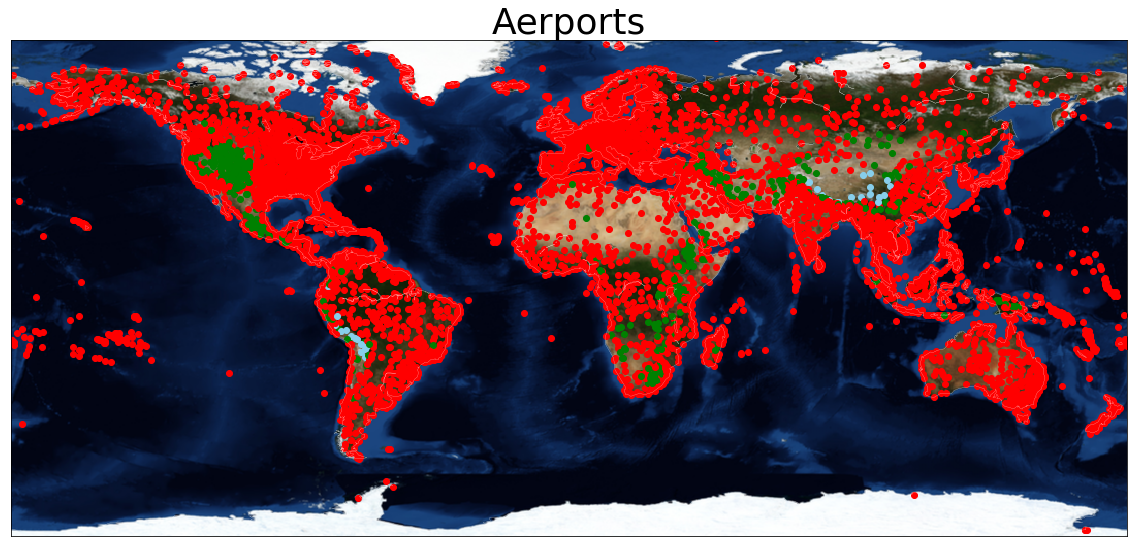

In [3]:
plt.rcParams["font.size"] = 30

fig = plt.gcf()
fig.set_size_inches(20, 20)

m = Basemap(projection='cyl', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(list(df['Longitude']),list(df['Latitude']))  # transform coordinates

colors = ['red','green','skyblue'] # Aerodrome bojimo na mapi u zavisnosti od visinske kategorije
category_altitude = list(df['Altitude_CATEGORY'])

plt.title("Aerports")
for i in range(0,len(x)):
    plt.scatter(x[i],y[i], color = colors[category_altitude[i] - 1])

plt.show()

## Preprocesiranje podataka
### Odabir karakteristika i skaliranje raspona svih atributa na interval $(0,1)$
Isto ćemo prvobitno vršiti klasterovanje u odnosu na atribute *Longitude*, *Latitude* i 
*Altitude* .

In [139]:
features = ['Longitude','Latitude','Altitude']
x = df[features]

scaler = MinMaxScaler().fit(x)
x = pd.DataFrame(scaler.transform(x))
x.columns = features

x.head()

Longitude  Latitude  Altitude
0   0.903957  0.486433  0.416063
1   0.905060  0.491502  0.081713
2   0.900911  0.487910  0.422798
3   0.907664  0.483603  0.095628
4   0.909037  0.466947  0.089719

## Primena algoritma

Počećemo od max - veze.
Na osnovu nje ćemo generisati matricu rastojanja i na osnovu nje nacrtati dendogram.
Posmatrajući dendogram ćemo procenjivati vrednosti za prag spajanja klastera.

In [70]:
# Boje za vizuelizaciju klastera
colors = ['red','deepskyblue','gold','lightgreen','palevioletred','purple','orangered',
          'blueviolet','darkblue','cadetblue','indigo','tomato','mediumaquamarine',
          'olive','c','maroon','darkseagreen','cornflowerblue','orchid','lightcoral',
          'lavender','slateblue','yellowgreen','forestgreen','antiquewhite', 'sienna',
          'darkcyan','deeppink','thistle','plum','powderblue','sandybrown','m',
          'chartreuse','lemonchiffon','mistyrose','darkmagenta','brown','peru',
          'chocolate','royalblue']

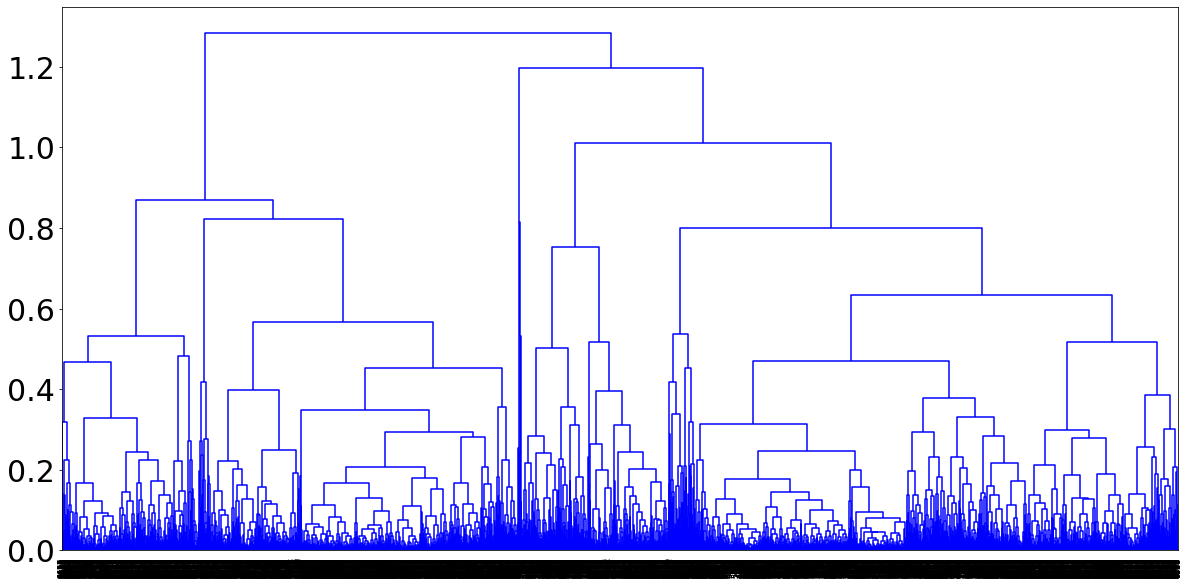

In [5]:
z = linkage(x,'complete') # z je matrica bliskosti klastera
 
plt.figure(figsize=(20,10))
den = dendrogram(z, labels = x.index ,
                 distance_sort= True,leaf_font_size = 8, color_threshold= 0)

In [71]:
# Funkcija za opisivanje klastera
def describe_clusters(df, features ,n): # n - broj klastera
    if 'labels' not in df.columns:
        print("Ne postoji kolona sa klasterima ili se drugacije naziva")
        return
    print(" ~ Opis dobijenih klastera: ~\n\n\n")
    
    for i in range(1,n+1):
        this_cluster = df.loc[ df['labels'] == i]
        num_of_members = len(this_cluster)
        if num_of_members == 0: # Ako se dogodi da imamo prazan klaster
            continue              # Nema potrebe ispisivati informacije o njemu
        print("********** Klaster {} : **********\n\n\n".format(i))
        print("Udeo: {} % ".format( int((num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(this_cluster.describe()[features])
        print("\n\n\n\n\n")

In [72]:

def model_agglomerative(z,x,df,t):
    df['labels'] = fcluster(z, t = t, criterion = 'distance')

    print("Dobijeni senka " + str(silhouette_score(x.values,df['labels'])))
    
    n = max(df['labels']) + 1
    describe_clusters(df=df,n=n-1, features = features)
    
    plt.figure(figsize= (20,10))
    for i in range(1,n):
        cluster = df[df['labels'] == i]
        plt.scatter(cluster['Longitude'], cluster['Latitude'], color = colors[i], label = "cluster %d"%i)

    plt.legend(loc = 2, prop = {'size' : 10})
    plt.show()

Dobijeni senka 0.43178506219699125
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 12 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  924.000000  924.000000   924.000000
mean   -71.606538   -7.882899   648.391775
std     27.819582   19.278091   910.775232
min   -179.876999  -67.567500     0.000000
25%    -76.655900  -22.496275    39.000000
50%    -66.910148   -8.057350   236.500000
75%    -55.964550    9.075769   871.250000
max    -32.423302   24.063299  6186.000000






********** Klaster 2 : **********



Udeo: 1 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   80.000000  80.000000    80.000000
mean   -96.067698  19.451196  7204.662500
std     16.096221  19.042955  1131.381691
min   -155.554001 -22.921700  5016.000000
25%   -106.999748   2.189863  6442.000000
50%   -101.760002  20.533899  7024.000000
75%    -78.456427  36.844001  7870.750000
max    -66.177101  44.688400  9840.000000








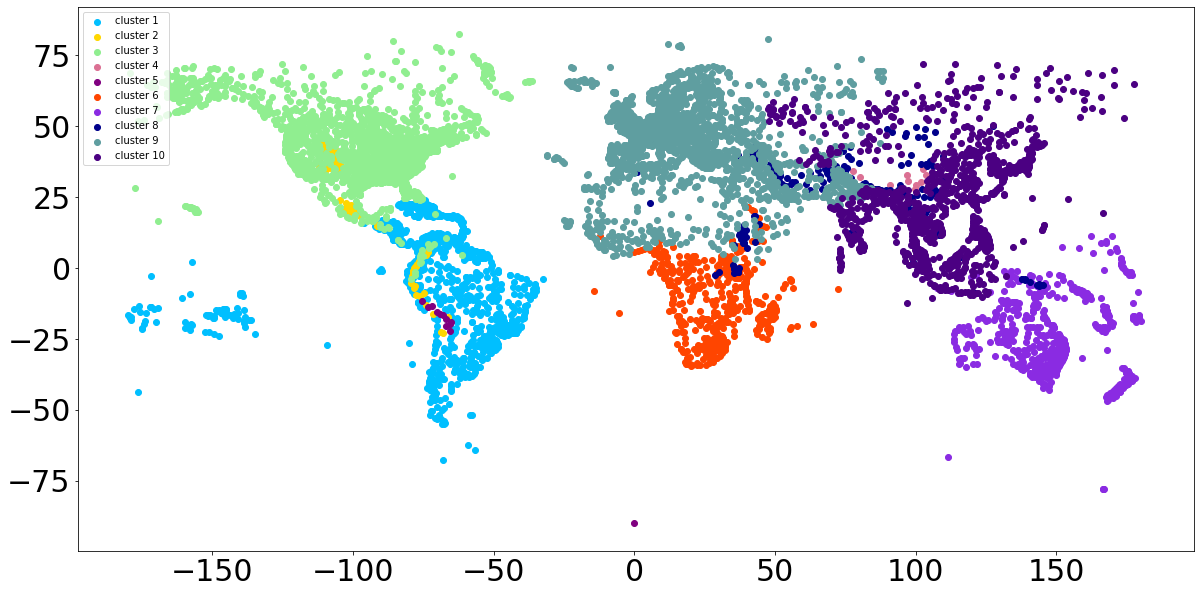

In [12]:
# Na osnovu dendograma, prvo 0.6 nam se čini kao najbolja opcija
model_agglomerative(z=z,x=x,df=df,t=0.6)

Dobijeni senka 0.3231936632357749


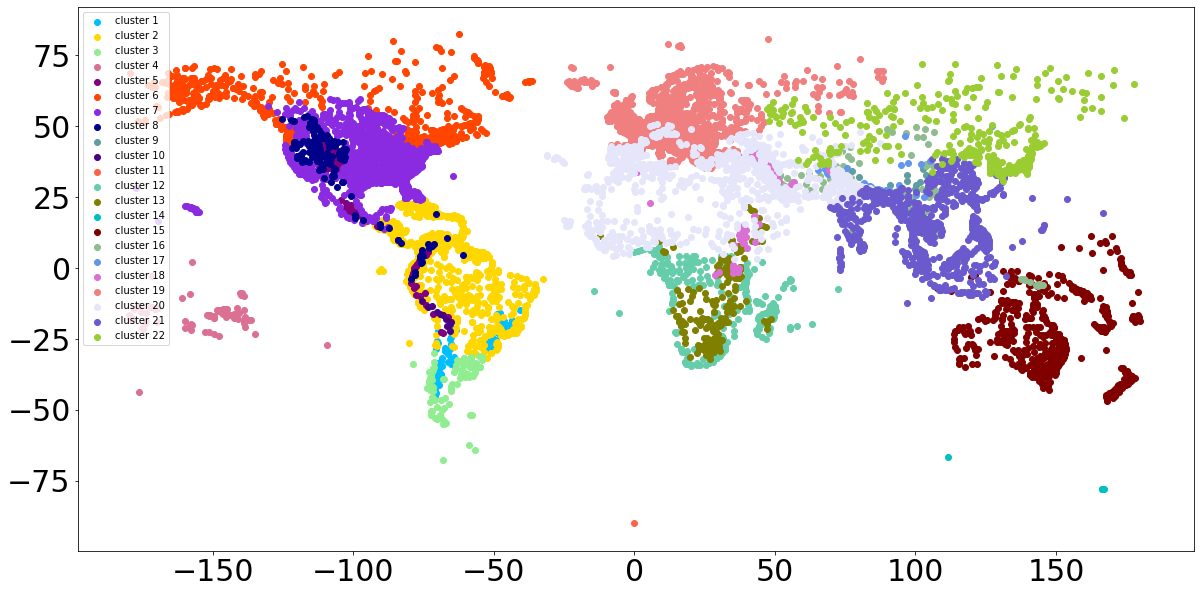

In [9]:
# I da vidimo kakav rezultat dobijamo za manji prag t
model_agglomerative(z=z,x=x,df=df,t=0.44)

### Analiza dosadašnjih rezultata i procene za dalje pokušaje

Ima malih klastera koji bi trebalo da budu deo velikih. Klasteri su međusobno isprepletani.


Dobijeni senka 0.37912851575057954


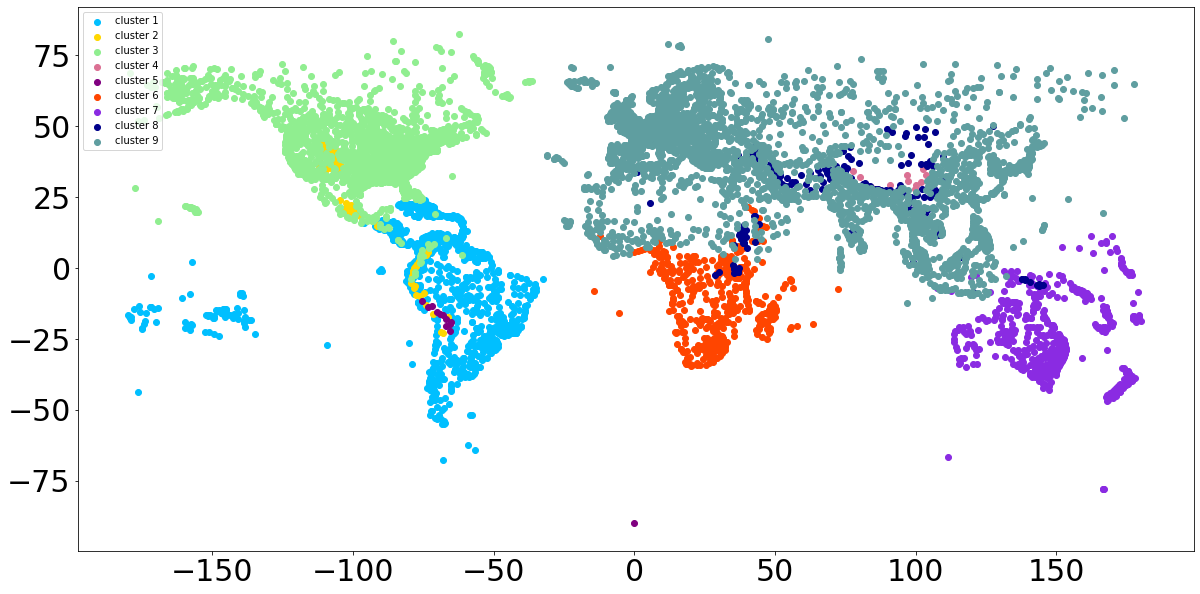

In [10]:
# Dalje pokušavamo, sad za veće vrednosti praga
model_agglomerative(z=z,df=df,x=x,t=0.64)

Dobijeni senka 0.37912851575057954


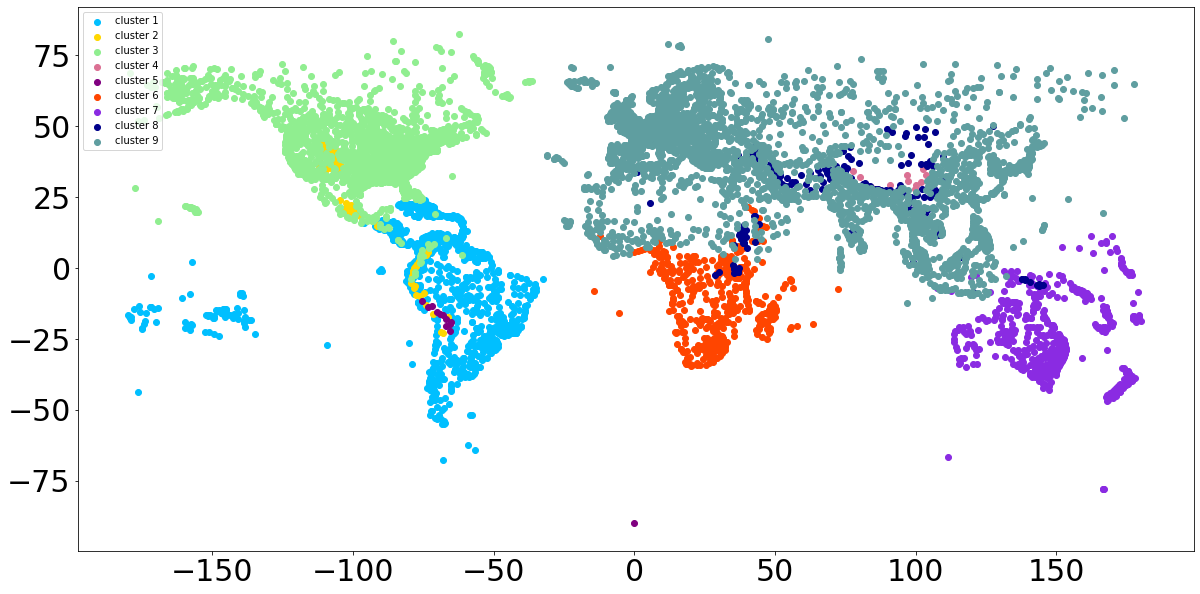

In [11]:
# Još povećavamo vrednost t
model_agglomerative(z=z,df=df,x=x,t=0.75)

Dobijeni senka 0.4098954040069277


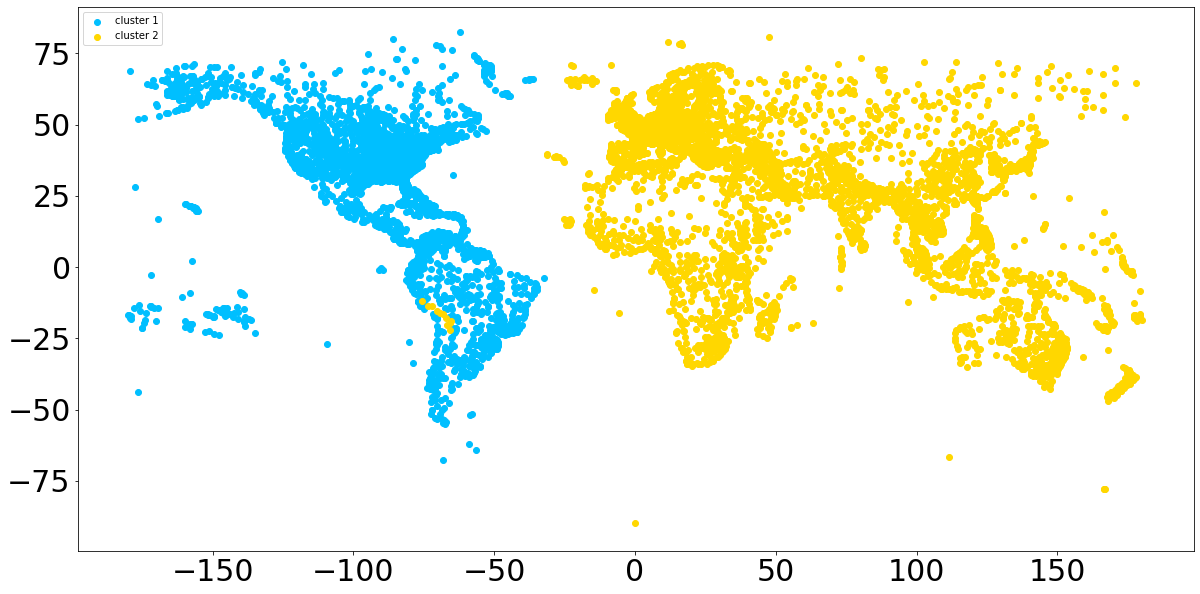

In [12]:
# Na kraju radi demonstracije, pusticemo za najvecu vrednost t = 1.2.
model_agglomerative(z=z,df=df,x=x,t=1.2)

S druge strane, za velike vrednosti praga su u 'obične' klastere obuhvaćeni i elementi van granica.

Sledeći kriterijum koji ćemo da probamo je prosečno rastojanje elemenata iz različitih klastera. Pravimo novu matricu rastojanja i novi dendogram, a koristićemo istu funkciju za formiranje klastera.

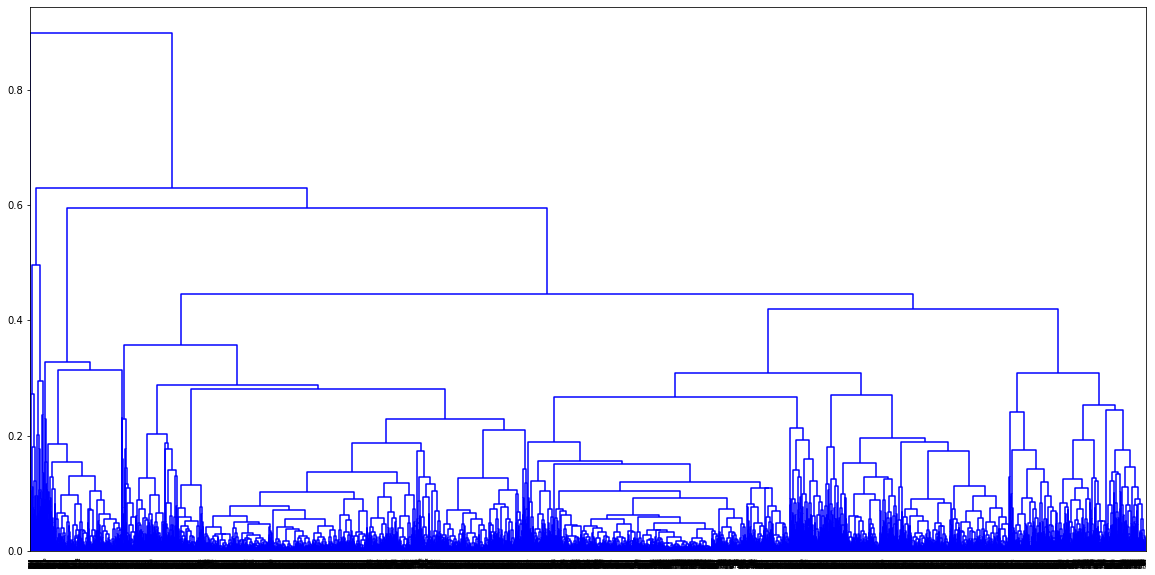

In [67]:
z = linkage(x,'average')

plt.figure(figsize= (20,10) )
den = dendrogram(z,labels = x.index, color_threshold=0, distance_sort= True, leaf_font_size= 4)

Dobijeni senka 0.3957119730069078
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude      Altitude
count  10.000000  10.000000     10.000000
mean  -69.343449 -16.729930  11930.700000
std     3.351100   3.306163    888.901076
min   -75.473396 -22.150600  10860.000000
25%   -71.493648 -19.147975  11177.000000
50%   -68.643947 -16.352199  11783.000000
75%   -66.905348 -14.146575  12581.250000
max   -65.577499 -11.783100  13355.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude     Altitude
count  29.000000  29.000000    29.000000
mean  -75.116945  -4.064819  7930.758621
std     3.940430   9.086507  1417.693364
min   -79.442902 -22.921700  4949.000000
25%   -78.136398  -9.347440  6955.000000
50%   -76.204803  -1.212070  8360.000000
75%   -74.064900   2.454400  8940.000000
max   -65.288696   8.582078  9840.000000






********** Klaster 3

       Longitude   Latitude    Altitude
count   5.000000   5.000000     5.00000
mean    4.919218  43.332781  5621.20000
std     5.805069   5.513172   632.21887
min    -5.152900  33.505299  4823.00000
25%     6.577942  45.396702  5459.00000
50%     6.634720  45.407003  5600.00000
75%     6.652220  45.820801  5636.00000
max     9.884110  46.534100  6588.00000






********** Klaster 22 : **********



Udeo: 3 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  229.000000  229.000000   229.000000
mean    50.292773   35.837889  3681.510917
std     30.286702    5.949734  1143.248502
min    -16.341499   24.107300  1427.000000
25%     32.995098   31.722601  2731.000000
50%     50.827999   35.702999  3428.000000
75%     71.745003   39.856899  4493.000000
max    109.861389   49.663300  6723.000000






********** Klaster 23 : **********



Udeo: 1 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   89.000000  89.000000    89.000000
m

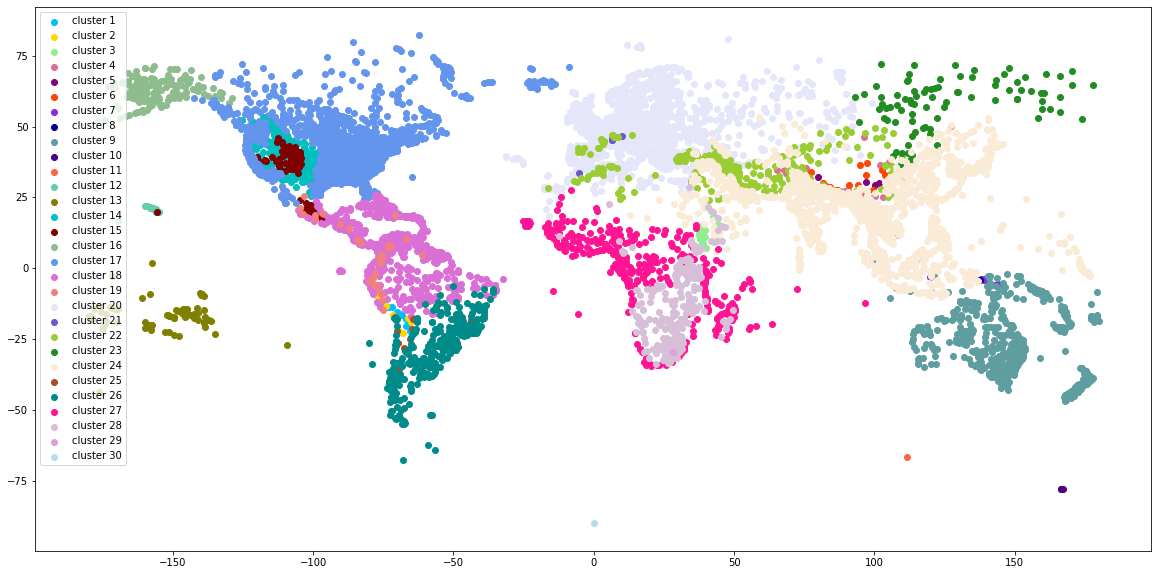

In [73]:
# Počećemo od manje vrednosti praga 
model_agglomerative(df=df,x=x,z=z,t=0.2)

Dobijeni senka 0.40373546433410723
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude      Altitude
count  10.000000  10.000000     10.000000
mean  -69.343449 -16.729930  11930.700000
std     3.351100   3.306163    888.901076
min   -75.473396 -22.150600  10860.000000
25%   -71.493648 -19.147975  11177.000000
50%   -68.643947 -16.352199  11783.000000
75%   -66.905348 -14.146575  12581.250000
max   -65.577499 -11.783100  13355.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude     Altitude
count  29.000000  29.000000    29.000000
mean  -75.116945  -4.064819  7930.758621
std     3.940430   9.086507  1417.693364
min   -79.442902 -22.921700  4949.000000
25%   -78.136398  -9.347440  6955.000000
50%   -76.204803  -1.212070  8360.000000
75%   -74.064900   2.454400  8940.000000
max   -65.288696   8.582078  9840.000000






********** Klaster 

       Longitude   Latitude    Altitude
count  10.000000  10.000000    10.00000
mean  -63.283710 -23.356290  4678.20000
std     9.875593   5.590267   896.91097
min   -70.930801 -35.493599  3475.00000
25%   -69.717474 -25.947325  4099.75000
50%   -66.533248 -21.992050  4463.00000
75%   -64.563675 -19.062925  5101.25000
max   -43.650398 -17.179001  6186.00000






********** Klaster 22 : **********



Udeo: 4 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  323.000000  323.000000   323.000000
mean   -56.364703  -28.259506  1138.377709
std     10.303094   10.770148  1020.354314
min    -80.096199  -67.567500     3.000000
25%    -65.125599  -34.599100   171.500000
50%    -55.837495  -26.332500   895.000000
75%    -48.049554  -21.280821  1953.500000
max    -35.896400   -6.115278  3731.000000






********** Klaster 23 : **********



Udeo: 4 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  324.000000  324.000000   324.000000

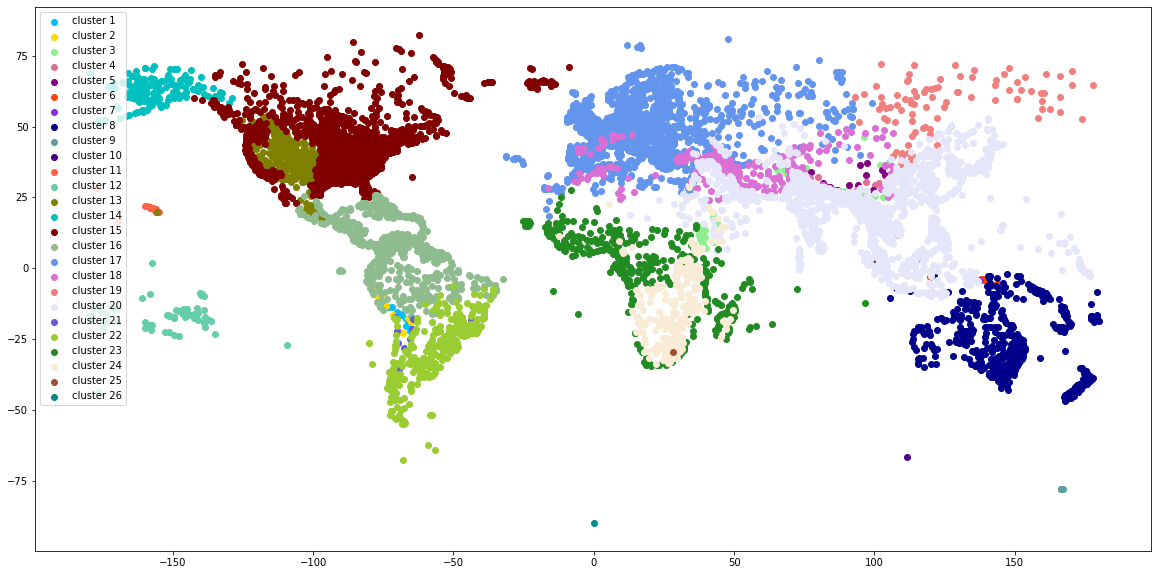

In [74]:
# Mnogo malih klastera u okviru velikih, međusobno isprepletani
model_agglomerative(df=df,x=x,z=z,t=0.22)

Dobijeni senka 0.4020917225602798
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude      Altitude
count  39.000000  39.000000     39.000000
mean  -73.636562  -7.312283   8956.384615
std     4.541293   9.737260   2190.638595
min   -79.442902 -22.921700   4949.000000
25%   -77.689950 -16.266100   7692.000000
50%   -74.683296  -7.139180   8781.000000
75%   -69.626900   0.835716  10350.000000
max   -65.288696   8.582078  13355.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude      Altitude
count   57.000000  57.000000     57.000000
mean    73.922227  25.077658   8601.017544
std     26.766460  10.501613   2251.748214
min     35.552900   7.116063   5954.000000
25%     40.046303  14.146800   7119.000000
50%     82.819099  27.793600   7918.000000
75%     97.036389  32.836389   9380.000000
max    127.308884  50.171621  14472.000000






**

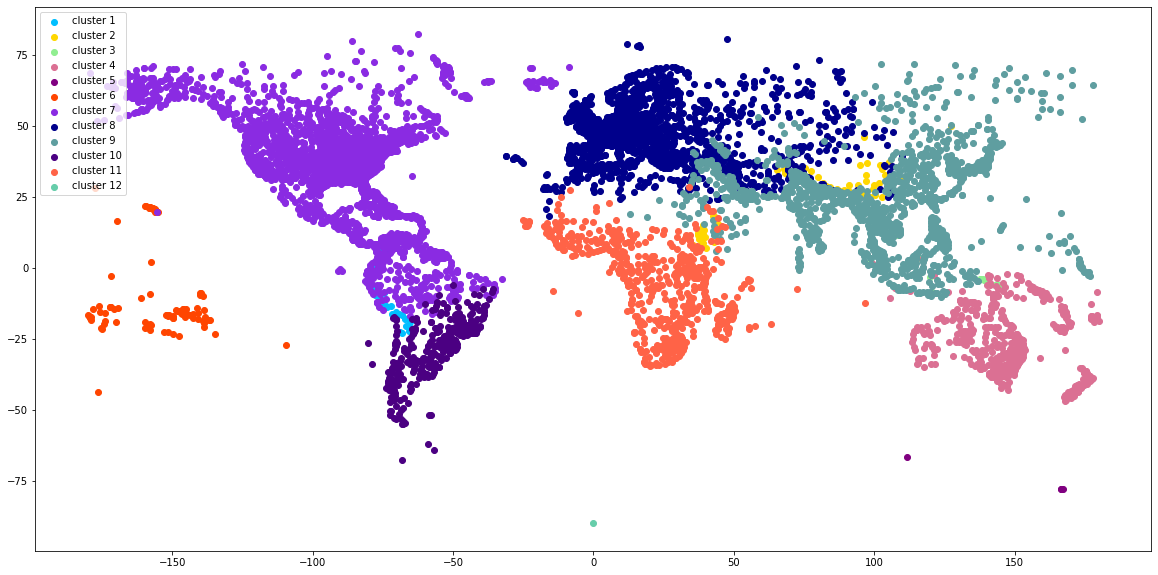

In [93]:
model_agglomerative(df=df,x=x,z=z,t=0.3)

Dobijeni senka 0.3957062023368207
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude      Altitude
count  39.000000  39.000000     39.000000
mean  -73.636562  -7.312283   8956.384615
std     4.541293   9.737260   2190.638595
min   -79.442902 -22.921700   4949.000000
25%   -77.689950 -16.266100   7692.000000
50%   -74.683296  -7.139180   8781.000000
75%   -69.626900   0.835716  10350.000000
max   -65.288696   8.582078  13355.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude      Altitude
count   57.000000  57.000000     57.000000
mean    73.922227  25.077658   8601.017544
std     26.766460  10.501613   2251.748214
min     35.552900   7.116063   5954.000000
25%     40.046303  14.146800   7119.000000
50%     82.819099  27.793600   7918.000000
75%     97.036389  32.836389   9380.000000
max    127.308884  50.171621  14472.000000






**

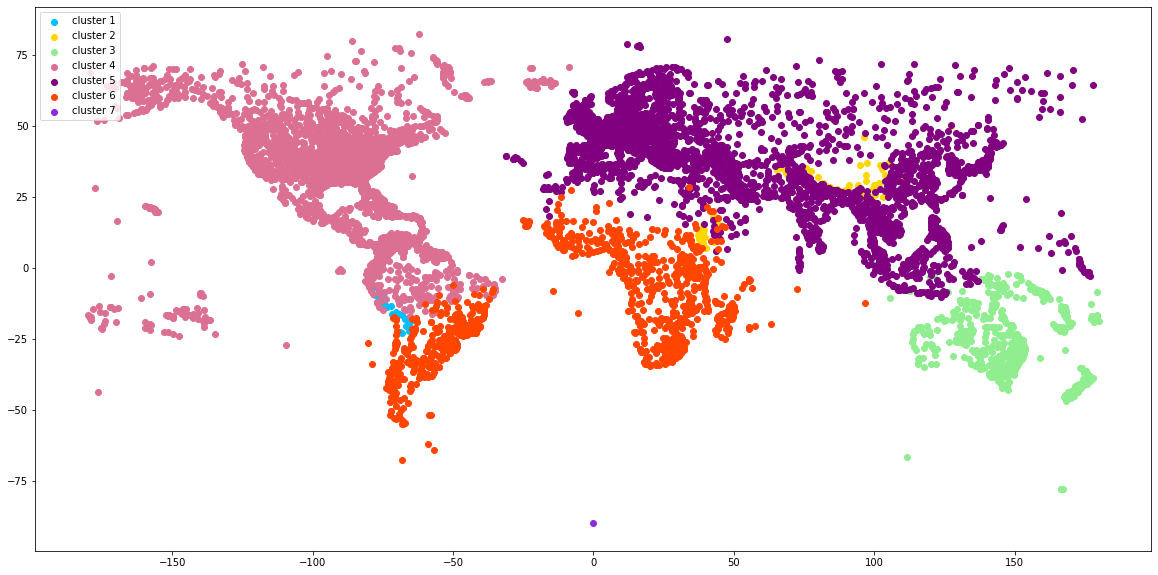

In [94]:
model_agglomerative(df=df,x=x,z=z,t=0.4)

Dobijeni senka 0.33234954577128634
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 1 % 
 - Deskriptivne statistike: 
        Longitude   Latitude      Altitude
count   96.000000  96.000000     96.000000
mean    13.976469  11.919244   8745.385417
std     75.748848  18.938196   2222.429038
min    -79.442902 -22.921700   4949.000000
25%    -73.345976  -1.322410   7199.500000
50%     38.855002  11.345300   8360.500000
75%     86.716724  29.057826   9783.750000
max    127.308884  50.171621  14472.000000






********** Klaster 2 : **********



Udeo: 6 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  525.000000  525.000000   525.000000
mean   147.403136  -24.624933   574.049524
std     16.965613   12.630238  1065.965148
min     98.991898  -77.963402     0.000000
25%    137.957000  -34.421398    20.000000
50%    146.356995  -24.903900   102.000000
75%    158.731003  -15.778100   646.000000
max    179.951004   16.375099  7989.00000

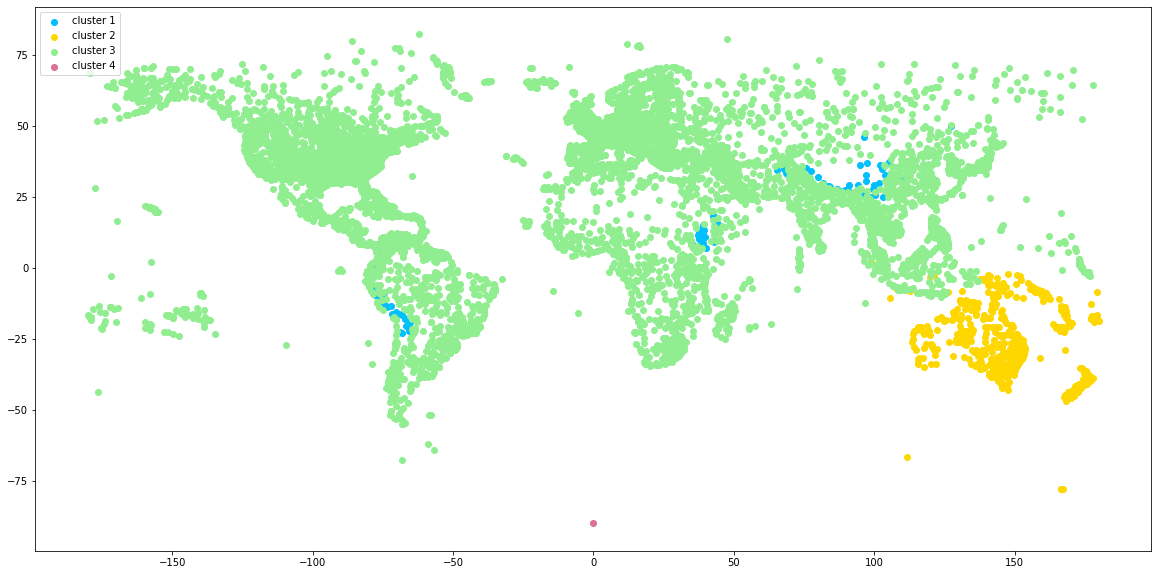

In [78]:
model_agglomerative(df=df,x=x,z=z,t=0.5)

Dobijeni senka 0.3916499904192137
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude      Altitude
count  10.000000  10.000000     10.000000
mean  -69.343449 -16.729930  11930.700000
std     3.351100   3.306163    888.901076
min   -75.473396 -22.150600  10860.000000
25%   -71.493648 -19.147975  11177.000000
50%   -68.643947 -16.352199  11783.000000
75%   -66.905348 -14.146575  12581.250000
max   -65.577499 -11.783100  13355.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude     Altitude
count  29.000000  29.000000    29.000000
mean  -75.116945  -4.064819  7930.758621
std     3.940430   9.086507  1417.693364
min   -79.442902 -22.921700  4949.000000
25%   -78.136398  -9.347440  6955.000000
50%   -76.204803  -1.212070  8360.000000
75%   -74.064900   2.454400  8940.000000
max   -65.288696   8.582078  9840.000000






********** Klaster 3

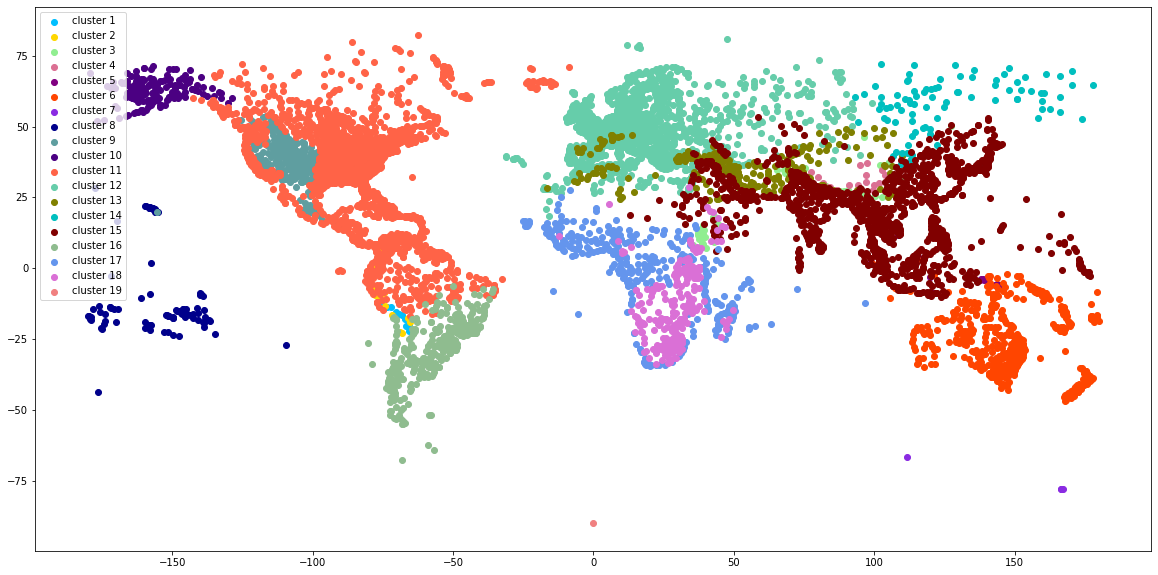

In [90]:
model_agglomerative(df=df,x=x,z=z,t=0.25)

Dobijeni senka 0.3693598160621639
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude      Altitude
count  39.000000  39.000000     39.000000
mean  -73.636562  -7.312283   8956.384615
std     4.541293   9.737260   2190.638595
min   -79.442902 -22.921700   4949.000000
25%   -77.689950 -16.266100   7692.000000
50%   -74.683296  -7.139180   8781.000000
75%   -69.626900   0.835716  10350.000000
max   -65.288696   8.582078  13355.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude      Altitude
count   57.000000  57.000000     57.000000
mean    73.922227  25.077658   8601.017544
std     26.766460  10.501613   2251.748214
min     35.552900   7.116063   5954.000000
25%     40.046303  14.146800   7119.000000
50%     82.819099  27.793600   7918.000000
75%     97.036389  32.836389   9380.000000
max    127.308884  50.171621  14472.000000






**

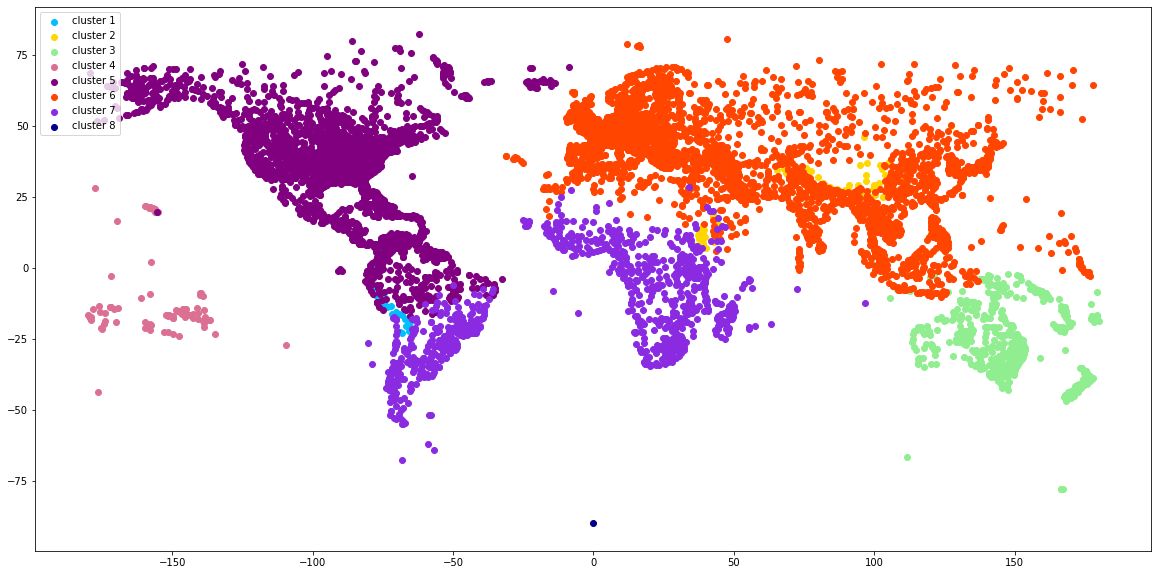

In [92]:
model_agglomerative(df=df,x=x,z=z,t=0.35)

Sad ćemo da pokušamo sa kriterijumom *Ward*-ove metode.

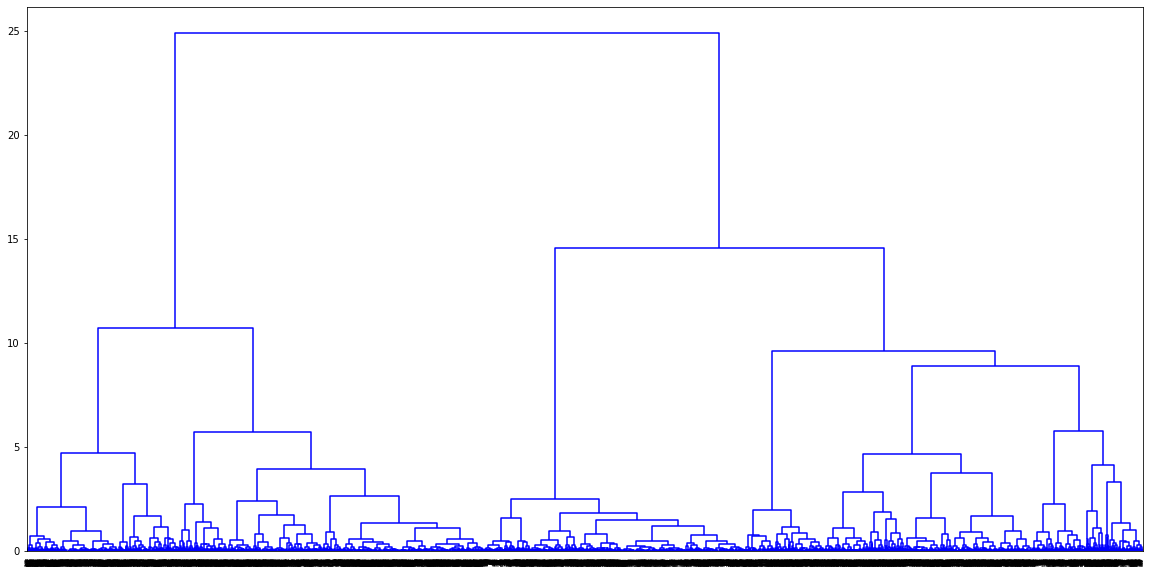

In [138]:
z = linkage(x,method = "ward")

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

Dobijeni senka 0.3734469506750985
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 13 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  1033.000000  1033.000000  1033.000000
mean    -72.855057    -4.395998   585.160697
std      26.650089    20.900756   881.346751
min    -179.876999   -67.567500     0.000000
25%     -79.996957   -21.267200    26.000000
50%     -69.533333    -3.382940   178.000000
75%     -57.223000    12.501400   748.000000
max     -32.423302    29.635500  6186.000000






********** Klaster 2 : **********



Udeo: 27 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  2055.000000  2055.000000  2055.000000
mean    -98.541266    43.420255  1161.689538
std      27.270391    12.628696  1581.661077
min    -179.373001    -9.878810  -115.000000
25%    -115.084000    34.989500   125.000000
50%     -94.255600    41.639702   638.000000
75%     -81.004402    50.381099  1281.000000
max   

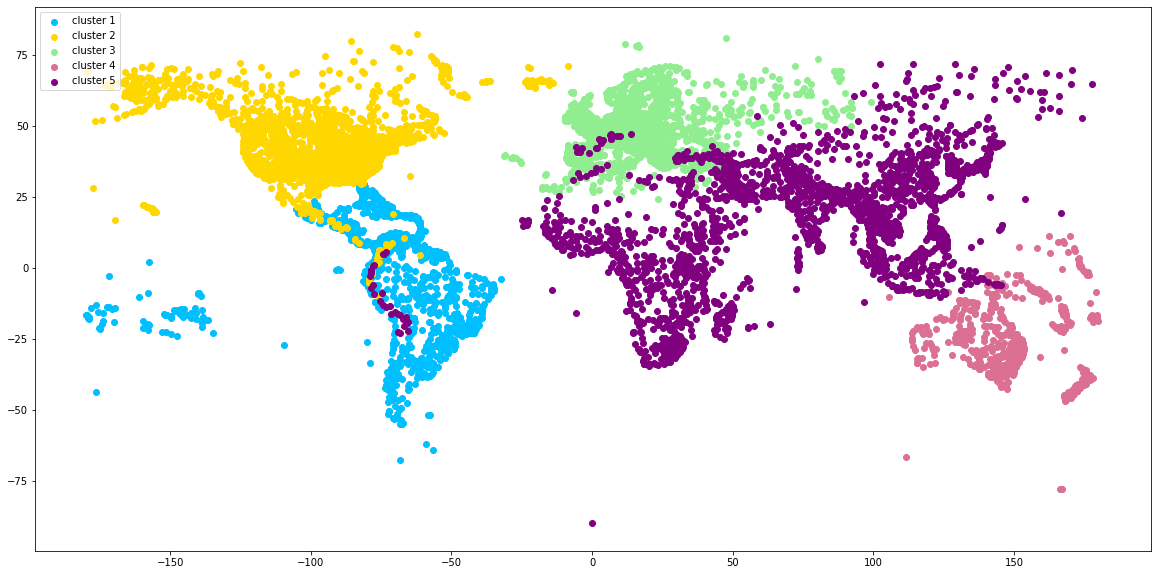

In [164]:
model_agglomerative(df = df, x =x, z = z, t = 9.5)

Dobijeni senka 0.41001781823348193
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 13 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  1033.000000  1033.000000  1033.000000
mean    -72.855057    -4.395998   585.160697
std      26.650089    20.900756   881.346751
min    -179.876999   -67.567500     0.000000
25%     -79.996957   -21.267200    26.000000
50%     -69.533333    -3.382940   178.000000
75%     -57.223000    12.501400   748.000000
max     -32.423302    29.635500  6186.000000






********** Klaster 2 : **********



Udeo: 27 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  2055.000000  2055.000000  2055.000000
mean    -98.541266    43.420255  1161.689538
std      27.270391    12.628696  1581.661077
min    -179.373001    -9.878810  -115.000000
25%    -115.084000    34.989500   125.000000
50%     -94.255600    41.639702   638.000000
75%     -81.004402    50.381099  1281.000000
max  

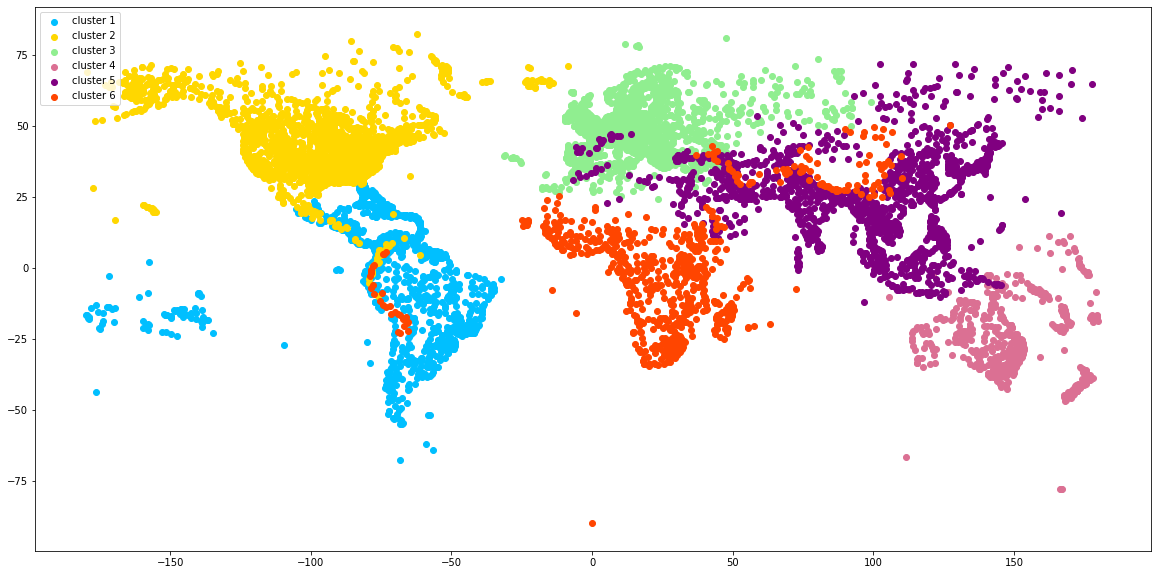

In [142]:
model_agglomerative(df = df, x =x, z = z, t = 5.8)

Dobijeni senka 0.4071194784844695


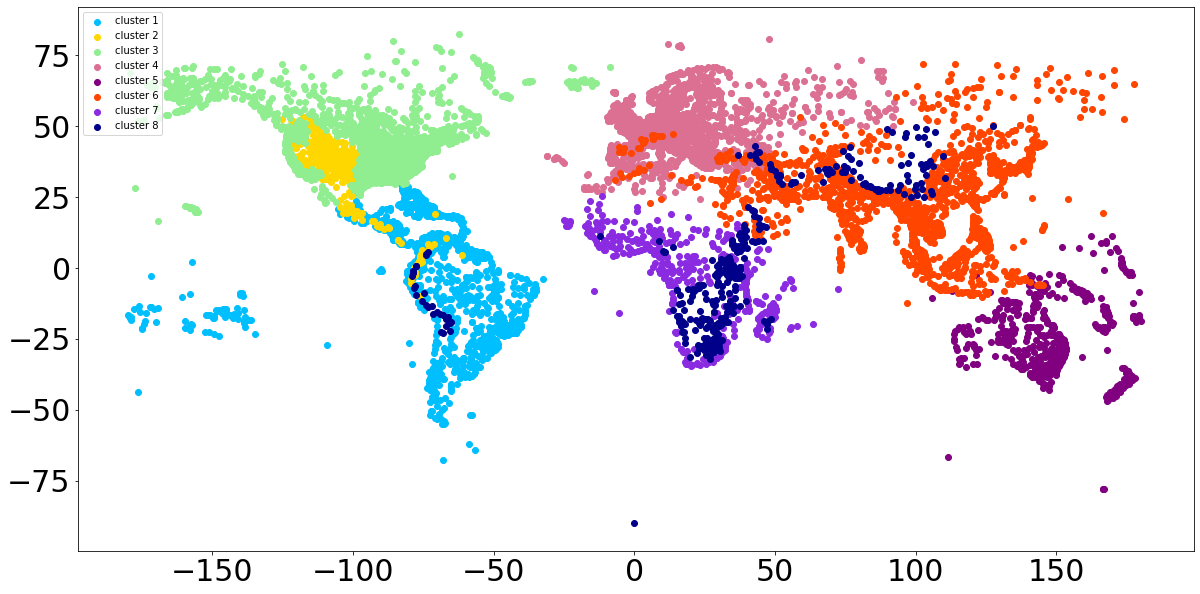

In [18]:
model_agglomerative(df = df, x =x, z = z, t = 5)

Dobijeni senka 0.38444732647386015
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  414.000000  414.000000   414.000000
mean   -74.564081  -25.702894  1050.763285
std     39.272764   11.052834  1166.872971
min   -179.876999  -67.567500     0.000000
25%    -71.584351  -32.603525    61.750000
50%    -59.021399  -23.023750   567.500000
75%    -49.410224  -17.760374  1846.250000
max    -35.896400    1.986160  6186.00000

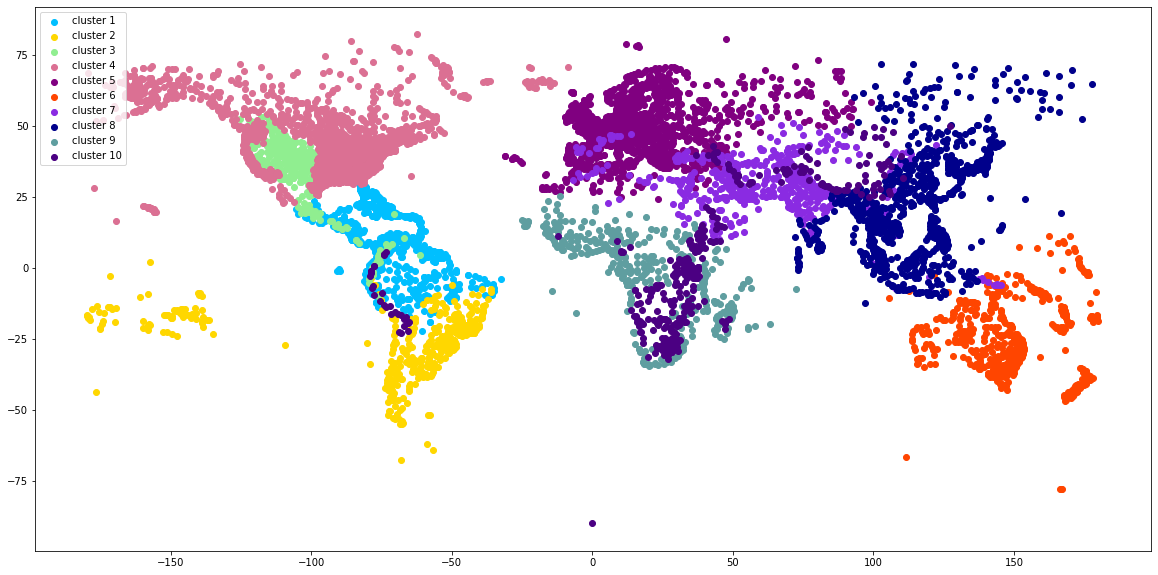

In [146]:
model_agglomerative(df=df,x=x,z=z,t= 4.2)

Dobijeni senka 0.38030329083924447
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  414.000000  414.000000   414.000000
mean   -74.564081  -25.702894  1050.763285
std     39.272764   11.052834  1166.872971
min   -179.876999  -67.567500     0.000000
25%    -71.584351  -32.603525    61.750000
50%    -59.021399  -23.023750   567.500000
75%    -49.410224  -17.760374  1846.250000
max    -35.896400    1.986160  6186.00000

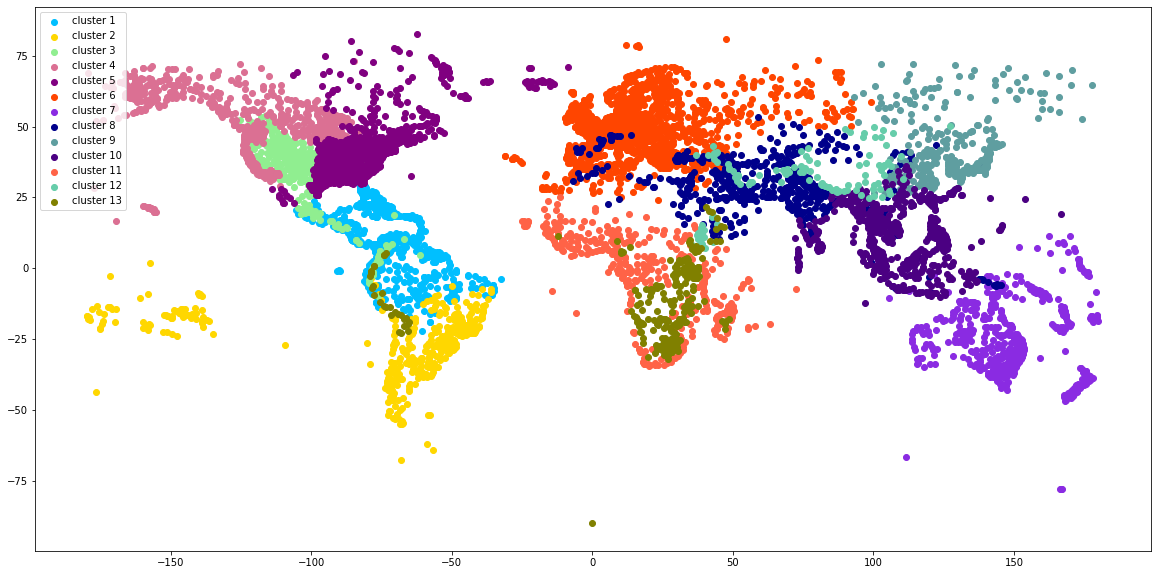

In [148]:
model_agglomerative(df=df,x=x,z=z,t= 3.5)

Dobijeni senka 0.3946237638660166
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   74.000000  74.000000    74.000000
mean  -154.925188 -16.617647    61.756757
std     14.050066   5.358011   180.541409
min   -179.876999 -43.810001     0.000000
25%   -170.513905 -18.731326     8.250000
50%   -149.684494 -16.635300    13.000000
75%   -145.049744 -14.519225    41.250000
max   -134.889999   1.986160  1481.000000






**

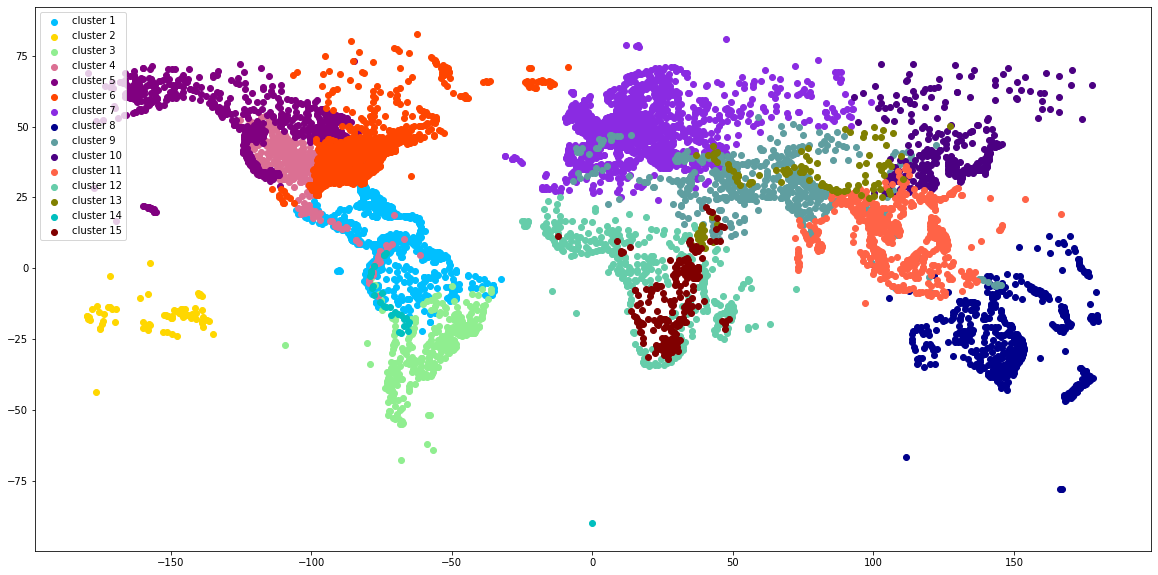

In [149]:
model_agglomerative(df=df,x=x,z=z,t= 3)

Dobijeni senka 0.380577019426981
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   74.000000  74.000000    74.000000
mean  -154.925188 -16.617647    61.756757
std     14.050066   5.358011   180.541409
min   -179.876999 -43.810001     0.000000
25%   -170.513905 -18.731326     8.250000
50%   -149.684494 -16.635300    13.000000
75%   -145.049744 -14.519225    41.250000
max   -134.889999   1.986160  1481.000000






***

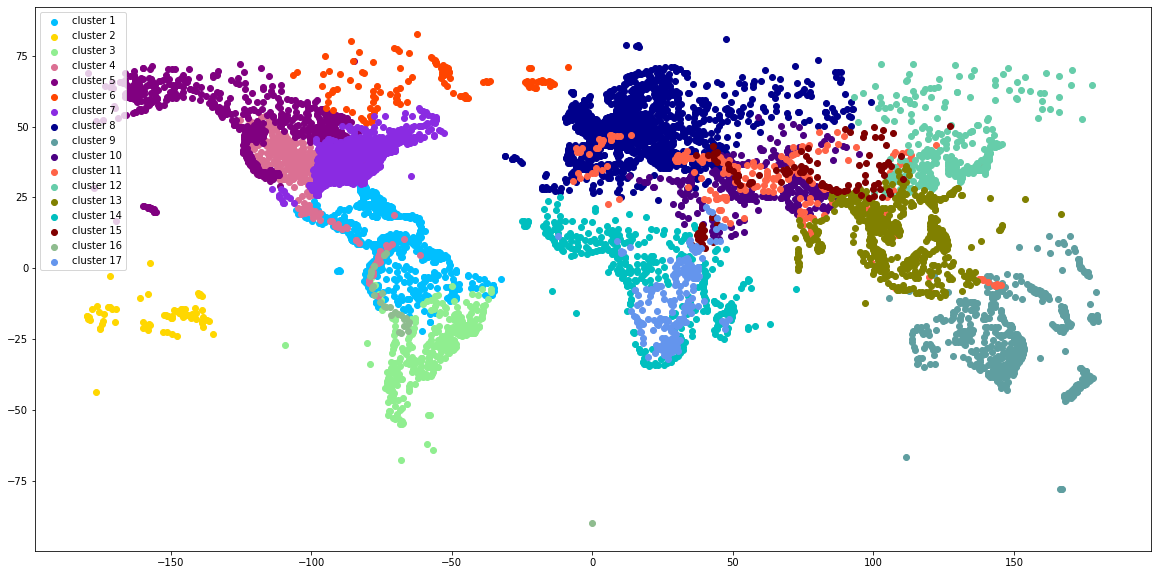

In [154]:
model_agglomerative(df=df,x=x,z=z,t= 2.5)

Dobijeni senka 0.3257530963003043
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 3 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  228.000000  228.000000   228.000000
mean   -62.726185   -2.714677   549.254386
std     12.160248    6.795161   478.453894
min    -90.953003  -22.049999     0.000000
25%    -72.543475   -7.939781   177.000000
50%    -61.506789   -2.823615   455.500000
75%    -54.786033    3.352150   796.250000
max    -32.423302   10.286111  2145.000000






********** Klaster 2 : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
        Longitude    Latitude    Altitude
count  391.000000  391.000000  391.000000
mean   -76.951853   17.183832  113.107417
std      8.949147    7.017656  161.365976
min   -105.253998    0.978519    0.000000
25%    -82.518132   10.479250   13.000000
50%    -77.847504   17.997000   38.000000
75%    -70.198732   22.813800  141.500000
max    -59.492500   29.635500  861.000000






**

        Longitude    Latitude     Altitude
count  546.000000  546.000000   546.000000
mean   108.279653   12.070017   232.161172
std     15.455136   10.630414   383.408183
min     72.176003  -12.188300     0.000000
25%     99.004123    3.706255    23.000000
50%    108.185497   12.365591    75.000000
75%    120.645750   21.440825   277.000000
max    166.636002   36.132629  2434.000000






********** Klaster 21 : **********



Udeo: 1 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  144.000000  144.000000   144.000000
mean    37.730973  -18.577917   586.597222
std     11.436443    9.411775   761.683095
min     14.568100  -34.554901     0.000000
25%     31.030320  -25.939885    36.000000
50%     39.582649  -17.852791   171.000000
75%     45.675910  -12.476075  1033.750000
max     72.411102    2.014440  2782.000000






********** Klaster 22 : **********



Udeo: 2 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  220.0000

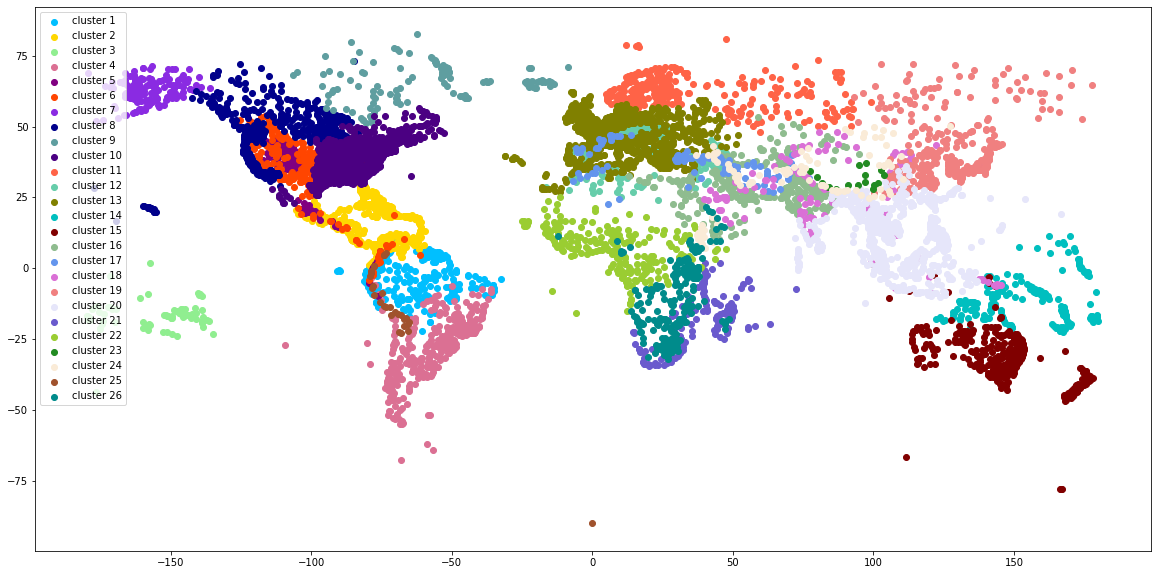

In [152]:
model_agglomerative(df=df,x=x,z=z,t= 1.8)

Na kraju ćemo ipak pokušati i sa kriterijumom Min - veze, iako na osnovu samih podataka možemo videti da nije dobar izbor. (Ređi delovi su veoma blizu gustih)

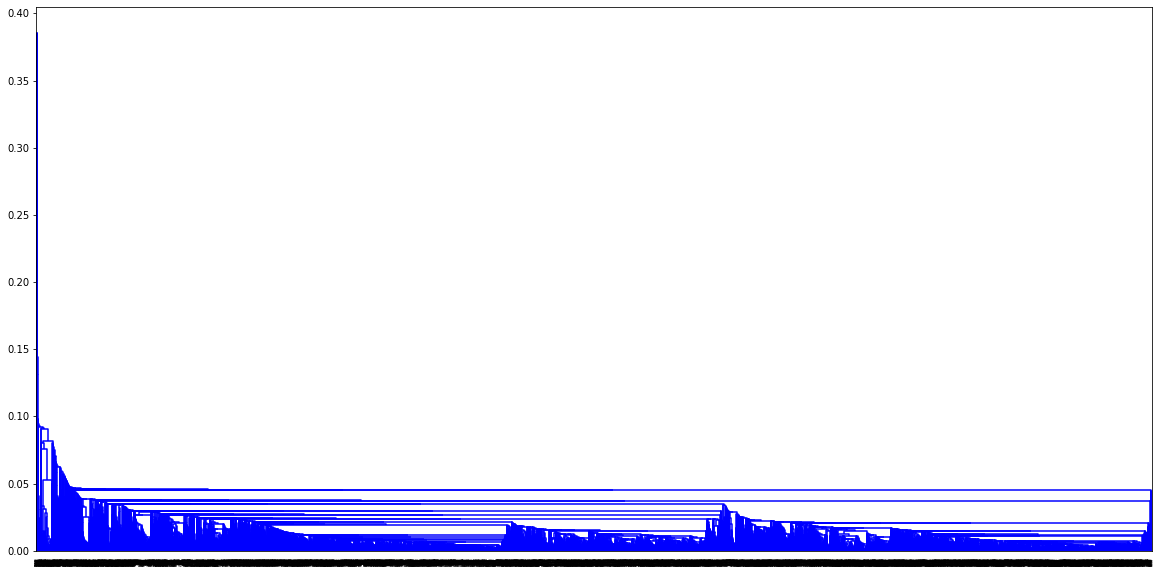

In [127]:
z = linkage(x,method = "single")

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

Dobijeni senka -0.2537669422028764
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude  Altitude
count    3.000000   3.000000   3.00000
mean   166.683665 -77.894933  29.00000
std      0.324534   0.059673  34.82815
min    166.468994 -77.963402   1.00000
25%    166.496994 -77.915402   9.50000
50%    166.524994 -77.867401  18.00000
75%    166.791000 -77.860698  43.00000
max    167.057007 -77.853996  68.00000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   19.000000  19.000000    19.000000
mean  -158.894240  21.132800   188.842105
std      5.433318   2.079539   338.962676
min   -177.380997  16.728600     7.000000
25%   -158.133508  20.525451    23.500000
50%   -157.095993  21.152901    47.000000
75%   -156.237798  21.467000   136.000000
max   -155.048004  28.201700  1308.000000






********** Klaster 3 : **********





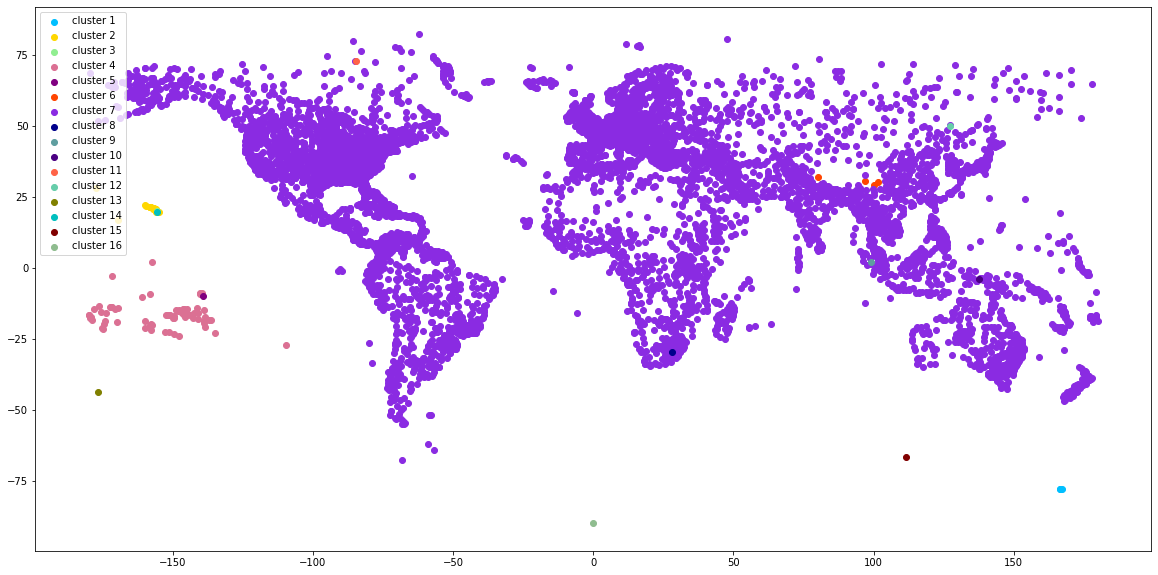

In [136]:
model_agglomerative(df = df, x =x, z = z, t = 0.08)

Sada i na osnovu dendograma možemo videti da, kao što smo na početku pretpostavili, nema mnogo smisla pokušavati sa Min - vezom.

Sada ćemo da klasterujemo samo na osnovu koordinata 'Longitude' i 'Latitude'.

In [29]:
features = ['Longitude','Latitude']

scaler = MinMaxScaler()
scaler.fit(df[features])
x = pd.DataFrame(scaler.transform(x),columns = features)


x.head()

Longitude  Latitude
0   0.502409  0.524505
1   0.502412  0.524534
2   0.502401  0.524513
3   0.502420  0.524489
4   0.502423  0.524392

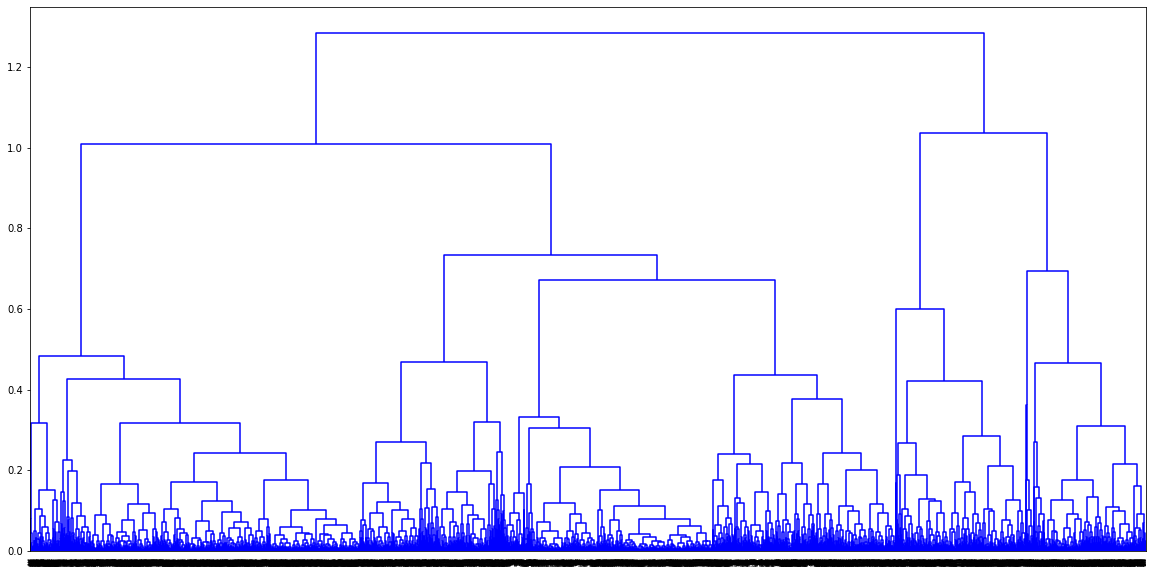

In [10]:
z = linkage(x,method = 'complete')

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

In [30]:

def model_agglomerative(z,x,df,t):
    df['labels'] = fcluster(z, t = t, criterion = 'distance')

    print("Dobijeni senka " + str(silhouette_score(x,df['labels'])))
    
    n = max(df['labels']) + 1
    describe_clusters(df=df,n=n-1, features = features)
    
    plt.figure(figsize= (20,10))
    for i in range(1,n):
        cluster = df[df['labels'] == i]
        plt.scatter(cluster['Longitude'], cluster['Latitude'], color = colors[i], label = "cluster %d"%i)

    plt.legend(loc = 2, prop = {'size' : 10})
    plt.show()

Dobijeni senka 0.3149037641720663
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 29 % 
 - Deskriptivne statistike: 
         Longitude     Latitude
count  2227.000000  2227.000000
mean    -98.430313    40.264500
std      24.721338    12.875502
min    -179.373001     9.738520
25%    -112.295997    32.726302
50%     -92.156097    39.901199
75%     -81.004402    47.872299
max     -52.751900    82.517799






********** Klaster 2 : **********



Udeo: 13 % 
 - Deskriptivne statistike: 
        Longitude    Latitude
count  991.000000  991.000000
mean    79.548454   42.778703
std     44.770432   10.650608
min     13.629200   20.451300
25%     35.491900   35.820801
50%     80.379669   40.976898
75%    121.081997   48.818751
max    177.740997   73.517807






********** Klaster 3 : **********



Udeo: 18 % 
 - Deskriptivne statistike: 
         Longitude     Latitude
count  1395.000000  1395.000000
mean      4.892499    51.725601
std      15.064466     8.414589
m

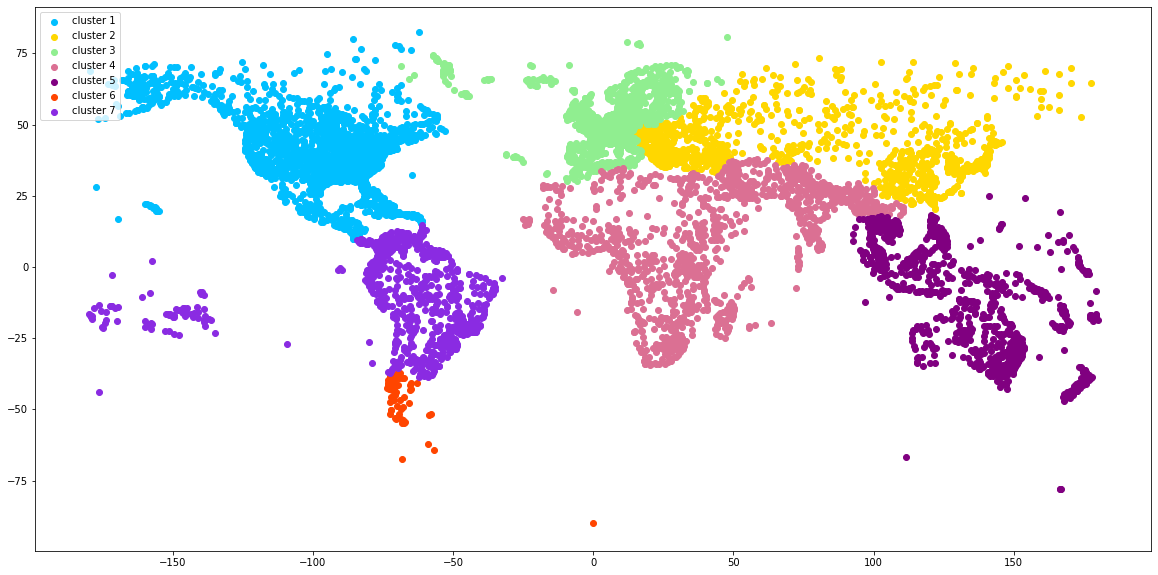

In [48]:
model_agglomerative(z = z, x = x,df = df, t = 0.63)

Dobijeni senka 0.322793562955088
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude
count   21.000000  21.000000
mean  -158.581550  21.013553
std      5.248283   2.008814
min   -177.380997  16.728600
25%   -158.070009  20.001301
50%   -156.973999  20.962900
75%   -156.014008  21.450500
max   -155.048004  28.201700






********** Klaster 2 : **********



Udeo: 2 % 
 - Deskriptivne statistike: 
        Longitude    Latitude
count  188.000000  188.000000
mean  -155.216762   62.337928
std     10.015377    3.887677
min   -179.373001   51.877998
25%   -162.335003   59.846149
50%   -157.212502   61.917450
75%   -149.047752   64.891949
max   -128.822006   71.285402






********** Klaster 3 : **********



Udeo: 2 % 
 - Deskriptivne statistike: 
        Longitude    Latitude
count  207.000000  207.000000
mean   -94.729032   57.051331
std     14.985755    7.538540
min   -135.005990   47.509399
25%   -101

        Longitude    Latitude
count  399.000000  399.000000
mean   -66.401698    0.953832
std     11.767830    7.650221
min    -90.953003  -14.859200
25%    -75.887899   -5.561885
50%    -68.574699    2.146400
75%    -58.912934    7.948020
max    -32.423302   14.591000






********** Klaster 26 : **********



Udeo: 3 % 
 - Deskriptivne statistike: 
        Longitude    Latitude
count  286.000000  286.000000
mean   -55.353304  -24.771660
std      9.966961    6.569603
min   -109.421997  -38.725000
25%    -63.162475  -29.612450
50%    -54.698650  -23.384577
75%    -47.409675  -20.485325
max    -38.322498  -11.885000








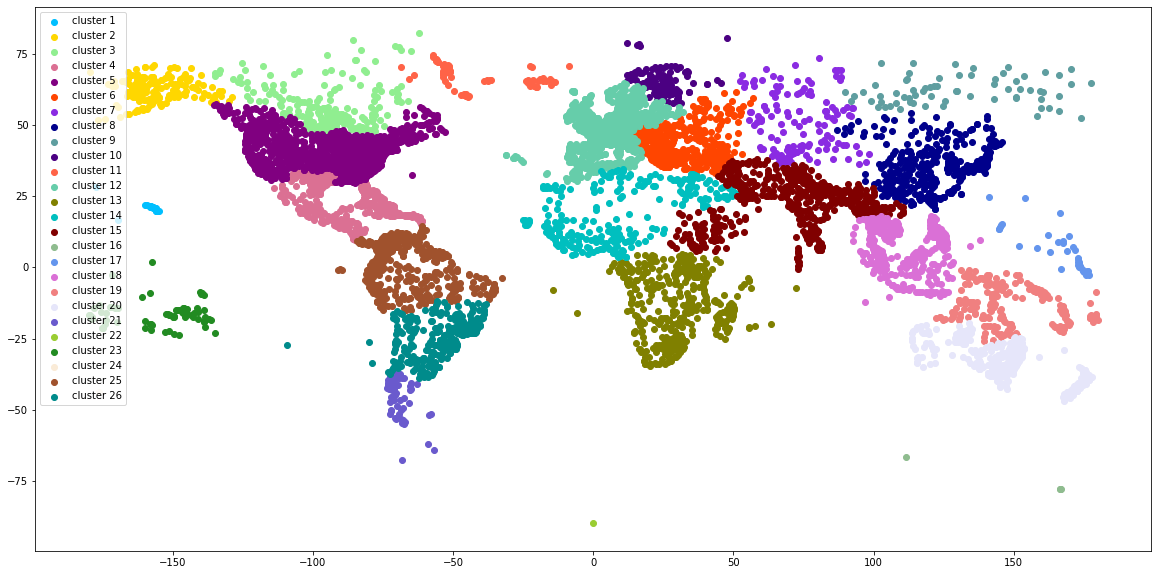

In [39]:
model_agglomerative(z = z, x = x,df = df, t = 0.25)

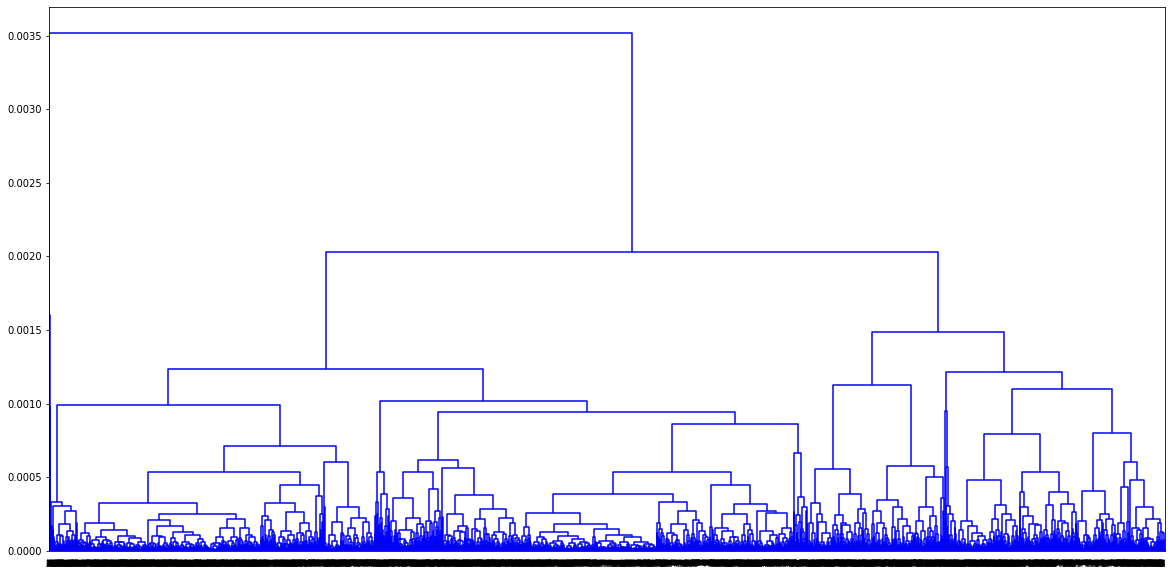

In [49]:
z = linkage(x,method = 'average')

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

Dobijeni senka 0.3818307016779285
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude
count    4.000000   4.000000
mean   152.893652 -75.093908
std     27.581300   5.602262
min    111.523611 -77.963402
25%    152.732648 -77.891401
50%    166.496994 -77.860698
75%    166.657997 -75.063205
max    167.057007 -66.690833






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude
count   4.000000   4.000000
mean  -45.936225 -70.999149
std    31.022969  12.859558
min   -68.127403 -90.000000
25%   -61.271874 -73.175625
50%   -57.808748 -65.902898
75%   -42.473098 -63.726423
max     0.000000 -62.190800






********** Klaster 3 : **********



Udeo: 29 % 
 - Deskriptivne statistike: 
         Longitude     Latitude
count  2192.000000  2192.000000
mean    -98.686818    40.410195
std      24.819551    12.330730
min    -179.373001    11.991000
25%    -112.6800

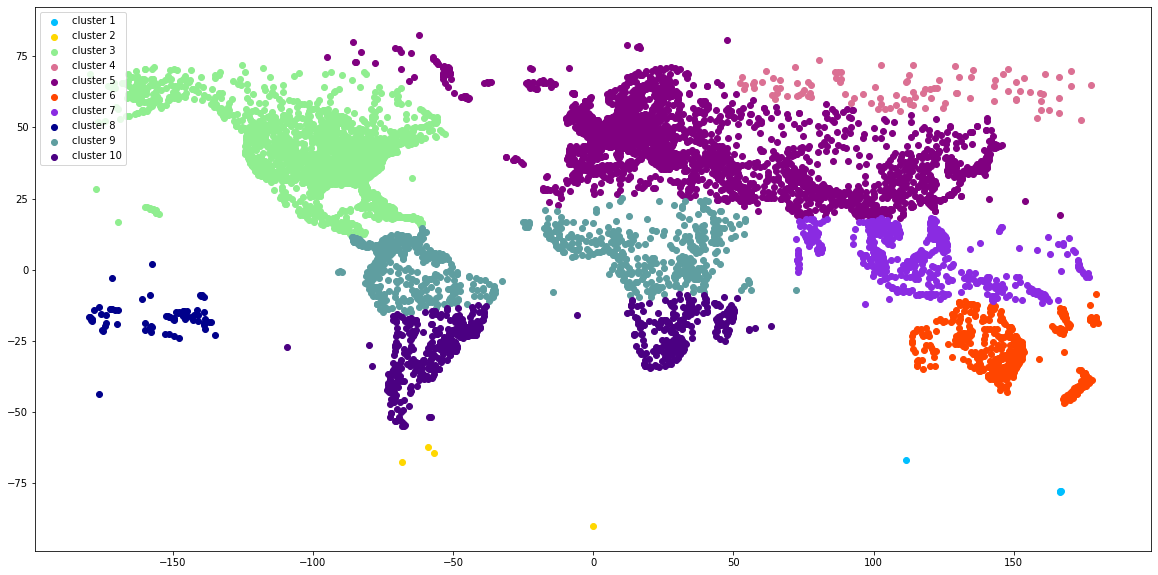

In [50]:
model_agglomerative(z = z, x = x,df = df, t = 0.0010)

Dobijeni senka 0.4078657436046717
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude
count    4.000000   4.000000
mean   152.893652 -75.093908
std     27.581300   5.602262
min    111.523611 -77.963402
25%    152.732648 -77.891401
50%    166.496994 -77.860698
75%    166.657997 -75.063205
max    167.057007 -66.690833






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude
count   4.000000   4.000000
mean  -45.936225 -70.999149
std    31.022969  12.859558
min   -68.127403 -90.000000
25%   -61.271874 -73.175625
50%   -57.808748 -65.902898
75%   -42.473098 -63.726423
max     0.000000 -62.190800






********** Klaster 3 : **********



Udeo: 29 % 
 - Deskriptivne statistike: 
         Longitude     Latitude
count  2192.000000  2192.000000
mean    -98.686818    40.410195
std      24.819551    12.330730
min    -179.373001    11.991000
25%    -112.6800

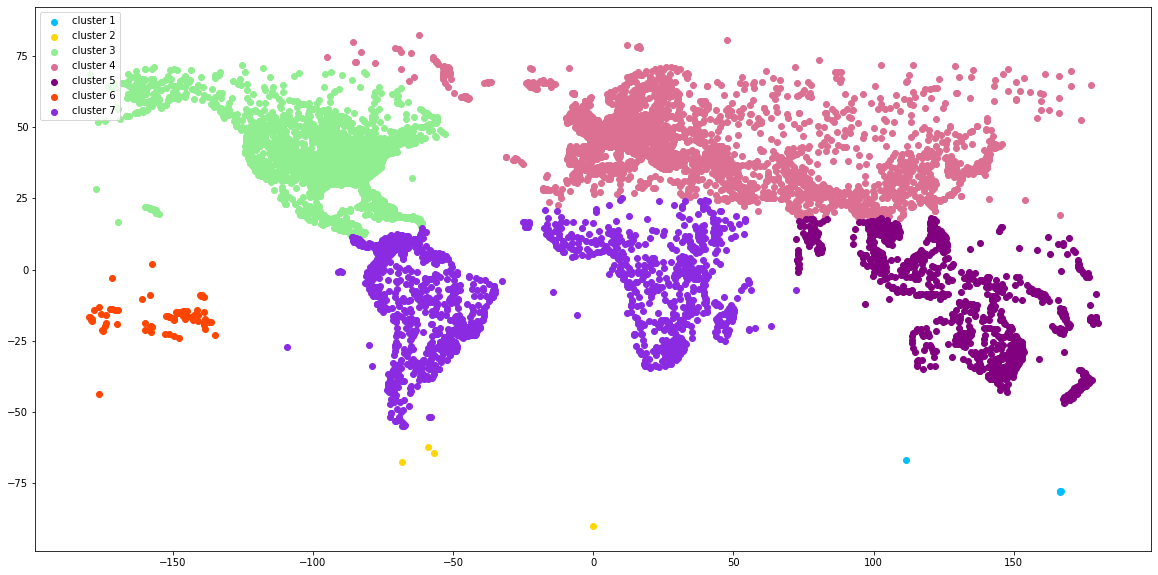

In [52]:
model_agglomerative(z = z, x = x,df = df, t = 0.0012)

In [165]:
model_agglomerative(z = z, x = x,df = df, t = 0.0010) 

Dobijeni senka 0.02899534892636976
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -76.986801 -0.462886     834.0
std          NaN       NaN       NaN
min   -76.986801 -0.462886     834.0
25%   -76.986801 -0.462886     834.0
50%   -76.986801 -0.462886     834.0
75%   -76.986801 -0.462886     834.0
max   -76.986801 -0.462886     834.0






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -76.337799 -0.122956     814.0
std          NaN       NaN       NaN
min   -76.337799 -0.122956     814.0
25%   -76.337799 -0.122956     814.0
50%   -76.337799 -0.122956     814.0
75%   -76.337799 -0.122956     814.0
max   -76.337799 -0.122956     814.0






********** Klaster 3 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latit

       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -79.391998  0.184203    1247.0
std          NaN       NaN       NaN
min   -79.391998  0.184203    1247.0
25%   -79.391998  0.184203    1247.0
50%   -79.391998  0.184203    1247.0
75%   -79.391998  0.184203    1247.0
max   -79.391998  0.184203    1247.0






********** Klaster 22 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000  1.000000       1.0
mean    -76.6056  0.978767    1248.0
std          NaN       NaN       NaN
min     -76.6056  0.978767    1248.0
25%     -76.6056  0.978767    1248.0
50%     -76.6056  0.978767    1248.0
75%     -76.6056  0.978767    1248.0
max     -76.6056  0.978767    1248.0






********** Klaster 23 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000    1.0000       1.0
mean    -72.4083   -0.5833    1250.0
std          NaN       NaN       NaN
min     -72.4083  

       Longitude   Latitude  Altitude
count    1.00000   1.000000       1.0
mean   -67.55732  10.183375    1450.0
std          NaN        NaN       NaN
min    -67.55732  10.183375    1450.0
25%    -67.55732  10.183375    1450.0
50%    -67.55732  10.183375    1450.0
75%    -67.55732  10.183375    1450.0
max    -67.55732  10.183375    1450.0






********** Klaster 43 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude  Altitude
count   1.000000   1.000000       1.0
mean  -67.649422  10.249978    1338.0
std          NaN        NaN       NaN
min   -67.649422  10.249978    1338.0
25%   -67.649422  10.249978    1338.0
50%   -67.649422  10.249978    1338.0
75%   -67.649422  10.249978    1338.0
max   -67.649422  10.249978    1338.0






********** Klaster 44 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude  Altitude
count   1.000000   1.000000       1.0
mean  -70.065216  10.175603    1437.0
std          NaN        NaN       

       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -80.678802 -0.946078      48.0
std          NaN       NaN       NaN
min   -80.678802 -0.946078      48.0
25%   -80.678802 -0.946078      48.0
50%   -80.678802 -0.946078      48.0
75%   -80.678802 -0.946078      48.0
max   -80.678802 -0.946078      48.0






********** Klaster 64 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -80.472198  -1.04165     130.0
std          NaN       NaN       NaN
min   -80.472198  -1.04165     130.0
25%   -80.472198  -1.04165     130.0
50%   -80.472198  -1.04165     130.0
75%   -80.472198  -1.04165     130.0
max   -80.472198  -1.04165     130.0






********** Klaster 65 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -77.114305  -12.0219     113.0
std          NaN       NaN       NaN
min   -77.114305  

       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -66.737503  -14.8592     633.0
std          NaN       NaN       NaN
min   -66.737503  -14.8592     633.0
25%   -66.737503  -14.8592     633.0
50%   -66.737503  -14.8592     633.0
75%   -66.737503  -14.8592     633.0
max   -66.737503  -14.8592     633.0






********** Klaster 85 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -62.259444  -13.0625     552.0
std          NaN       NaN       NaN
min   -62.259444  -13.0625     552.0
25%   -62.259444  -13.0625     552.0
50%   -62.259444  -13.0625     552.0
75%   -62.259444  -13.0625     552.0
max   -62.259444  -13.0625     552.0






********** Klaster 86 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -72.769501  -7.59991     637.0
std          NaN       NaN       NaN
min   -72.769501  

       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -59.909167 -9.936944     246.0
std          NaN       NaN       NaN
min   -59.909167 -9.936944     246.0
25%   -59.909167 -9.936944     246.0
50%   -59.909167 -9.936944     246.0
75%   -59.909167 -9.936944     246.0
max   -59.909167 -9.936944     246.0






********** Klaster 106 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000     1.000       1.0
mean    -61.4508   -11.496     778.0
std          NaN       NaN       NaN
min     -61.4508   -11.496     778.0
25%     -61.4508   -11.496     778.0
50%     -61.4508   -11.496     778.0
75%     -61.4508   -11.496     778.0
max     -61.4508   -11.496     778.0






********** Klaster 107 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude  Altitude
count   1.000000   1.000000       1.0
mean  -61.228889 -11.901667     748.0
std          NaN        NaN       NaN
min   -61.22

       Longitude  Latitude  Altitude
count     1.0000   1.00000       1.0
mean    -35.2477  -5.91142     169.0
std          NaN       NaN       NaN
min     -35.2477  -5.91142     169.0
25%     -35.2477  -5.91142     169.0
50%     -35.2477  -5.91142     169.0
75%     -35.2477  -5.91142     169.0
max     -35.2477  -5.91142     169.0






********** Klaster 127 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -34.948612 -7.145833     217.0
std          NaN       NaN       NaN
min   -34.948612 -7.145833     217.0
25%   -34.948612 -7.145833     217.0
50%   -34.948612 -7.145833     217.0
75%   -34.948612 -7.145833     217.0
max   -34.948612 -7.145833     217.0






********** Klaster 128 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -34.923599  -8.12649      33.0
std          NaN       NaN       NaN
min   -34.923599

       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -49.301498  -8.34835     653.0
std          NaN       NaN       NaN
min   -49.301498  -8.34835     653.0
25%   -49.301498  -8.34835     653.0
50%   -49.301498  -8.34835     653.0
75%   -49.301498  -8.34835     653.0
max   -49.301498  -8.34835     653.0






********** Klaster 147 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000   1.00000       1.0
mean    -49.9799  -8.03329     670.0
std          NaN       NaN       NaN
min     -49.9799  -8.03329     670.0
25%     -49.9799  -8.03329     670.0
50%     -49.9799  -8.03329     670.0
75%     -49.9799  -8.03329     670.0
max     -49.9799  -8.03329     670.0






********** Klaster 148 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -50.328499  -9.31997     597.0
std          NaN       NaN       NaN
min   -50.328499

       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -66.083199  -2.53261     207.0
std          NaN       NaN       NaN
min   -66.083199  -2.53261     207.0
25%   -66.083199  -2.53261     207.0
50%   -66.083199  -2.53261     207.0
75%   -66.083199  -2.53261     207.0
max   -66.083199  -2.53261     207.0






********** Klaster 167 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000  1.000000       1.0
mean  -62.919601 -0.981292     112.0
std          NaN       NaN       NaN
min   -62.919601 -0.981292     112.0
25%   -62.919601 -0.981292     112.0
50%   -62.919601 -0.981292     112.0
75%   -62.919601 -0.981292     112.0
max   -62.919601 -0.981292     112.0






********** Klaster 168 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude   Altitude
count   2.000000  2.000000   2.000000
mean  -48.468500 -1.396705  53.000000
std     0.011029  0.024685   1.414214
min   -48.47

       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -63.132599  -4.13406     131.0
std          NaN       NaN       NaN
min   -63.132599  -4.13406     131.0
25%   -63.132599  -4.13406     131.0
50%   -63.132599  -4.13406     131.0
75%   -63.132599  -4.13406     131.0
max   -63.132599  -4.13406     131.0






********** Klaster 187 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -53.204201   3.61361     656.0
std          NaN       NaN       NaN
min   -53.204201   3.61361     656.0
25%   -53.204201   3.61361     656.0
50%   -53.204201   3.61361     656.0
75%   -53.204201   3.61361     656.0
max   -53.204201   3.61361     656.0






********** Klaster 188 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -55.442501   3.34528     714.0
std          NaN       NaN       NaN
min   -55.442501

       Longitude  Latitude  Altitude
count     1.0000    1.0000       1.0
mean    -54.7861    4.0583     280.0
std          NaN       NaN       NaN
min     -54.7861    4.0583     280.0
25%     -54.7861    4.0583     280.0
50%     -54.7861    4.0583     280.0
75%     -54.7861    4.0583     280.0
max     -54.7861    4.0583     280.0






********** Klaster 207 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -58.270302   5.96592     180.0
std          NaN       NaN       NaN
min   -58.270302   5.96592     180.0
25%   -58.270302   5.96592     180.0
50%   -58.270302   5.96592     180.0
75%   -58.270302   5.96592     180.0
max   -58.270302   5.96592     180.0






********** Klaster 208 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000   1.00000       1.0
mean  -58.254101   6.49855      95.0
std          NaN       NaN       NaN
min   -58.254101

       Longitude  Latitude  Altitude
count   1.000000     1.000       1.0
mean  -92.817398    17.997      46.0
std          NaN       NaN       NaN
min   -92.817398    17.997      46.0
25%   -92.817398    17.997      46.0
50%   -92.817398    17.997      46.0
75%   -92.817398    17.997      46.0
max   -92.817398    17.997      46.0






********** Klaster 228 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -91.799004   18.6537      10.0
std          NaN       NaN       NaN
min   -91.799004   18.6537      10.0
25%   -91.799004   18.6537      10.0
50%   -91.799004   18.6537      10.0
75%   -91.799004   18.6537      10.0
max   -91.799004   18.6537      10.0






********** Klaster 229 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude   Latitude  Altitude
count   1.000000   1.000000       1.0
mean  -96.187302  19.145901      90.0
std          NaN        NaN       NaN
min   -96.18

       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -83.063797   12.1629       1.0
std          NaN       NaN       NaN
min   -83.063797   12.1629       1.0
25%   -83.063797   12.1629       1.0
50%   -83.063797   12.1629       1.0
75%   -83.063797   12.1629       1.0
max   -83.063797   12.1629       1.0






********** Klaster 248 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000    1.0000       1.0
mean    -81.3583   13.3569      10.0
std          NaN       NaN       NaN
min     -81.3583   13.3569      10.0
25%     -81.3583   13.3569      10.0
50%     -81.3583   13.3569      10.0
75%     -81.3583   13.3569      10.0
max     -81.3583   13.3569      10.0






********** Klaster 249 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000    1.0000       1.0
mean    -81.7112   12.5836      19.0
std          NaN       NaN       NaN
min     -81.7112

       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -86.852997   15.7425      39.0
std          NaN       NaN       NaN
min   -86.852997   15.7425      39.0
25%   -86.852997   15.7425      39.0
50%   -86.852997   15.7425      39.0
75%   -86.852997   15.7425      39.0
max   -86.852997   15.7425      39.0






********** Klaster 268 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count     1.0000    1.0000       1.0
mean    -87.4758   15.7759       7.0
std          NaN       NaN       NaN
min     -87.4758   15.7759       7.0
25%     -87.4758   15.7759       7.0
50%     -87.4758   15.7759       7.0
75%     -87.4758   15.7759       7.0
max     -87.4758   15.7759       7.0






********** Klaster 269 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
       Longitude  Latitude  Altitude
count   1.000000    1.0000       1.0
mean  -88.583801   15.7309      33.0
std          NaN       NaN       NaN
min   -88.583801

KeyboardInterrupt: 

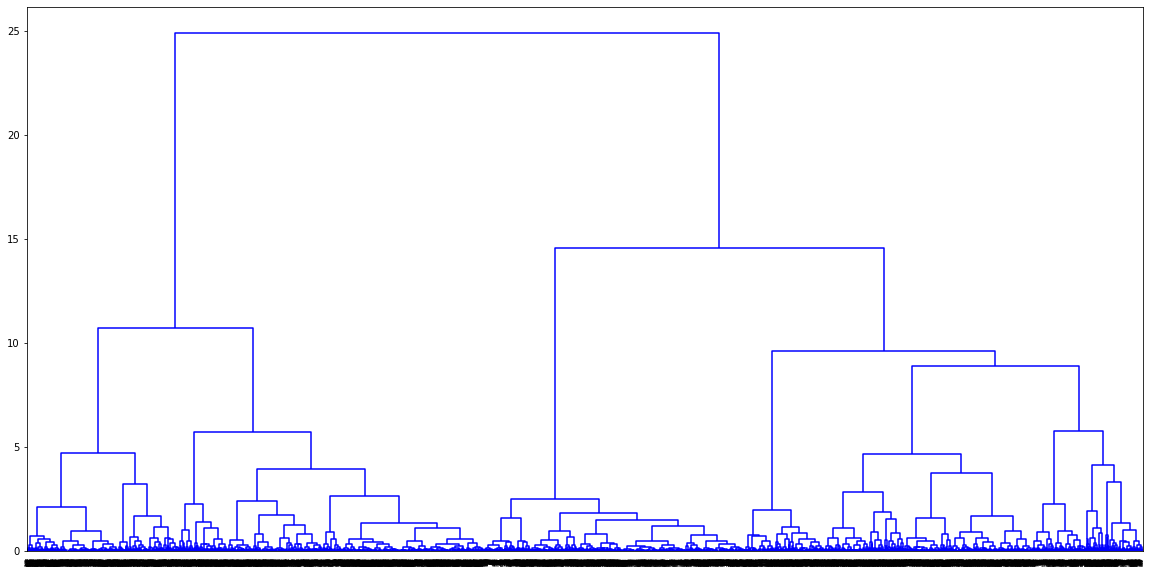

In [96]:
z = linkage(x, method = "ward")

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

Dobijeni senka 0.4071194784844695
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 13 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  1033.000000  1033.000000  1033.000000
mean    -72.855057    -4.395998   585.160697
std      26.650089    20.900756   881.346751
min    -179.876999   -67.567500     0.000000
25%     -79.996957   -21.267200    26.000000
50%     -69.533333    -3.382940   178.000000
75%     -57.223000    12.501400   748.000000
max     -32.423302    29.635500  6186.000000






********** Klaster 2 : **********



Udeo: 4 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  326.000000  326.000000   326.000000
mean  -104.036077   33.290510  4248.984663
std     12.555654   12.333319  1662.561585
min   -155.554001   -9.878810  1278.000000
25%   -112.068748   31.191000  2970.250000
50%   -105.915997   36.652251  4109.500000
75%   -100.391003   40.790350  5430.750000
max    -61.150002   53.

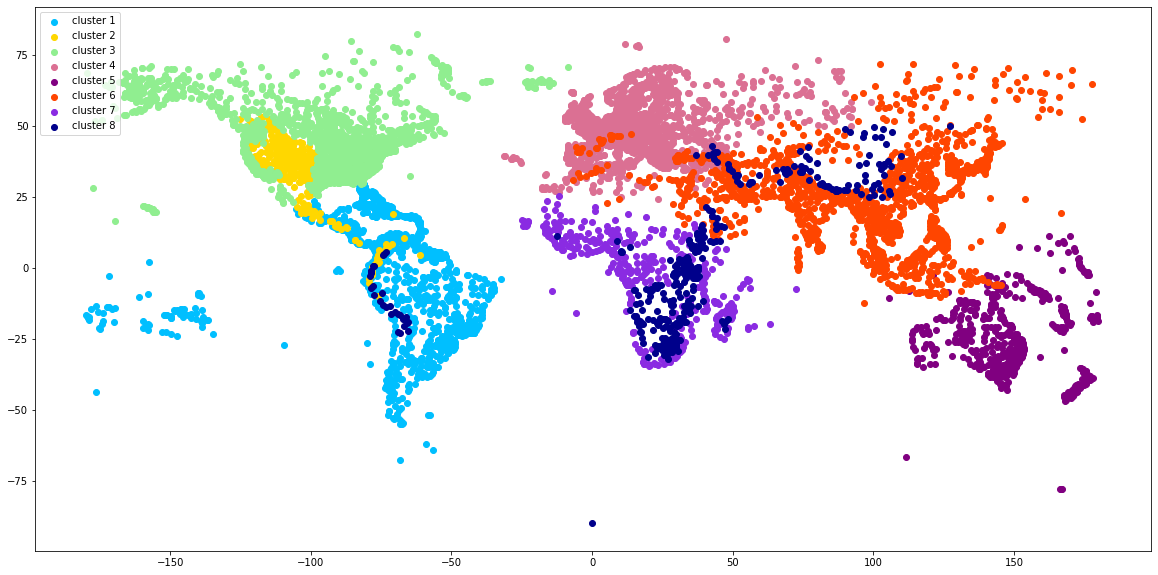

In [97]:
model_agglomerative(df = df, x =x, z = z, t = 5)

Dobijeni senka 0.38444732647386015
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  414.000000  414.000000   414.000000
mean   -74.564081  -25.702894  1050.763285
std     39.272764   11.052834  1166.872971
min   -179.876999  -67.567500     0.000000
25%    -71.584351  -32.603525    61.750000
50%    -59.021399  -23.023750   567.500000
75%    -49.410224  -17.760374  1846.250000
max    -35.896400    1.986160  6186.00000

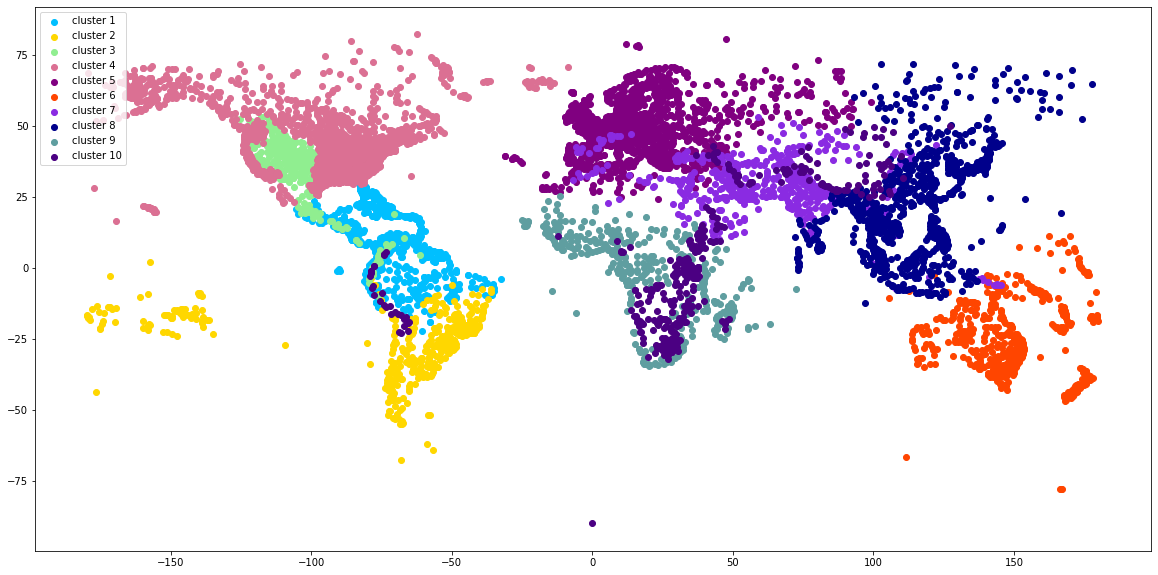

In [167]:
model_agglomerative(df = df, x =x, z = z, t = 4.5)

Dobijeni senka 0.3933803356867651
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  414.000000  414.000000   414.000000
mean   -74.564081  -25.702894  1050.763285
std     39.272764   11.052834  1166.872971
min   -179.876999  -67.567500     0.000000
25%    -71.584351  -32.603525    61.750000
50%    -59.021399  -23.023750   567.500000
75%    -49.410224  -17.760374  1846.250000
max    -35.896400    1.986160  6186.000000

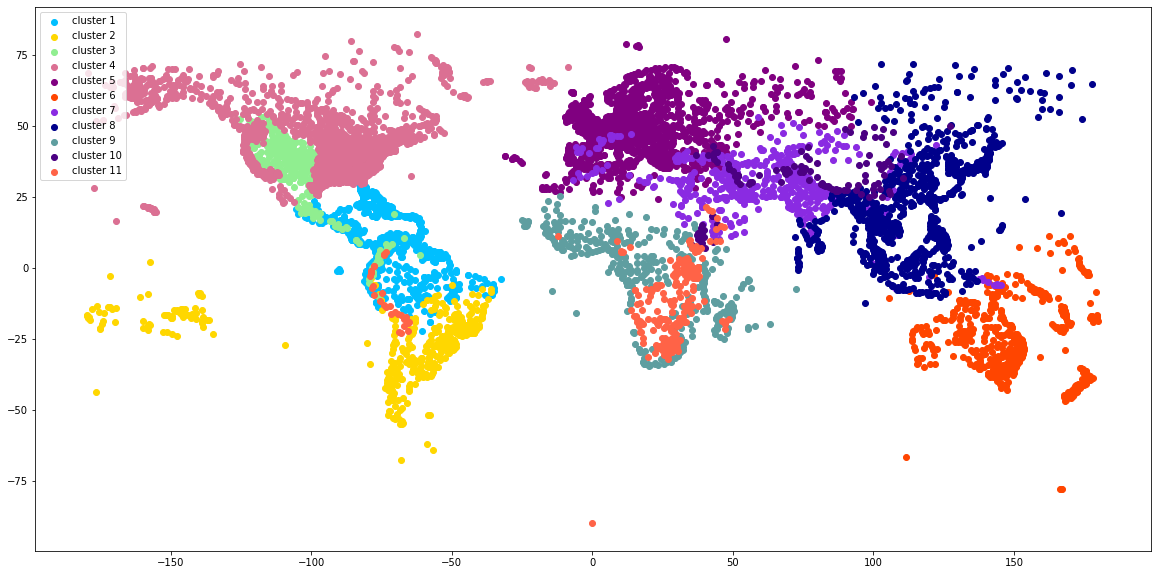

In [99]:
model_agglomerative(df = df, x =x, z = z, t = 4)

Dobijeni senka 0.38030329083924447
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  414.000000  414.000000   414.000000
mean   -74.564081  -25.702894  1050.763285
std     39.272764   11.052834  1166.872971
min   -179.876999  -67.567500     0.000000
25%    -71.584351  -32.603525    61.750000
50%    -59.021399  -23.023750   567.500000
75%    -49.410224  -17.760374  1846.250000
max    -35.896400    1.986160  6186.00000

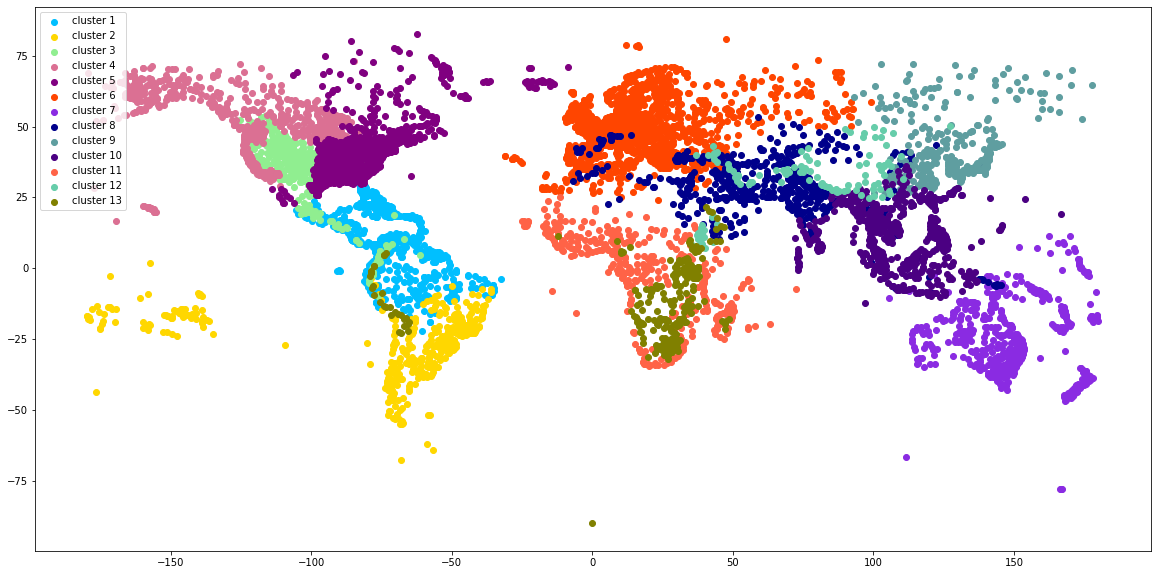

In [104]:
model_agglomerative(df = df, x =x, z = z, t = 3.5)

Dobijeni senka 0.3946237638660166
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 8 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  619.000000  619.000000   619.000000
mean   -71.712027    9.854494   273.756058
std     12.329486   11.845325   380.588001
min   -105.253998  -22.049999     0.000000
25%    -80.686100    0.687084    19.500000
50%    -73.970901   10.149733    98.000000
75%    -63.048044   19.232800   371.000000
max    -32.423302   29.635500  2145.000000






********** Klaster 2 : **********



Udeo: 0 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   74.000000  74.000000    74.000000
mean  -154.925188 -16.617647    61.756757
std     14.050066   5.358011   180.541409
min   -179.876999 -43.810001     0.000000
25%   -170.513905 -18.731326     8.250000
50%   -149.684494 -16.635300    13.000000
75%   -145.049744 -14.519225    41.250000
max   -134.889999   1.986160  1481.000000






**

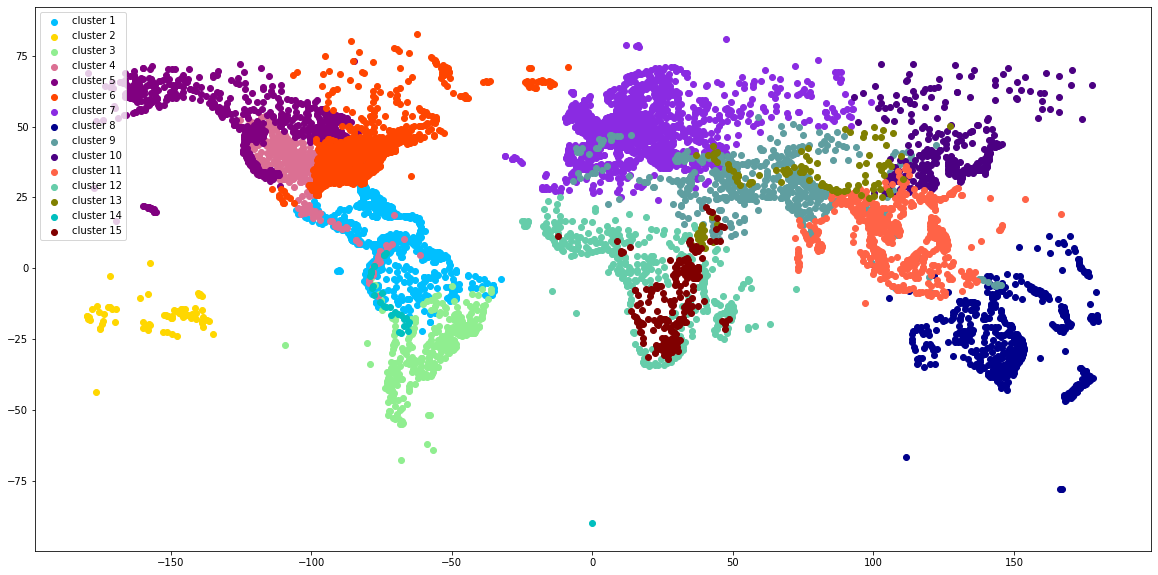

In [105]:
model_agglomerative(df = df, x =x, z = z, t = 3)

Dobijeni senka 0.41001781823348193
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 13 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  1033.000000  1033.000000  1033.000000
mean    -72.855057    -4.395998   585.160697
std      26.650089    20.900756   881.346751
min    -179.876999   -67.567500     0.000000
25%     -79.996957   -21.267200    26.000000
50%     -69.533333    -3.382940   178.000000
75%     -57.223000    12.501400   748.000000
max     -32.423302    29.635500  6186.000000






********** Klaster 2 : **********



Udeo: 27 % 
 - Deskriptivne statistike: 
         Longitude     Latitude     Altitude
count  2055.000000  2055.000000  2055.000000
mean    -98.541266    43.420255  1161.689538
std      27.270391    12.628696  1581.661077
min    -179.373001    -9.878810  -115.000000
25%    -115.084000    34.989500   125.000000
50%     -94.255600    41.639702   638.000000
75%     -81.004402    50.381099  1281.000000
max  

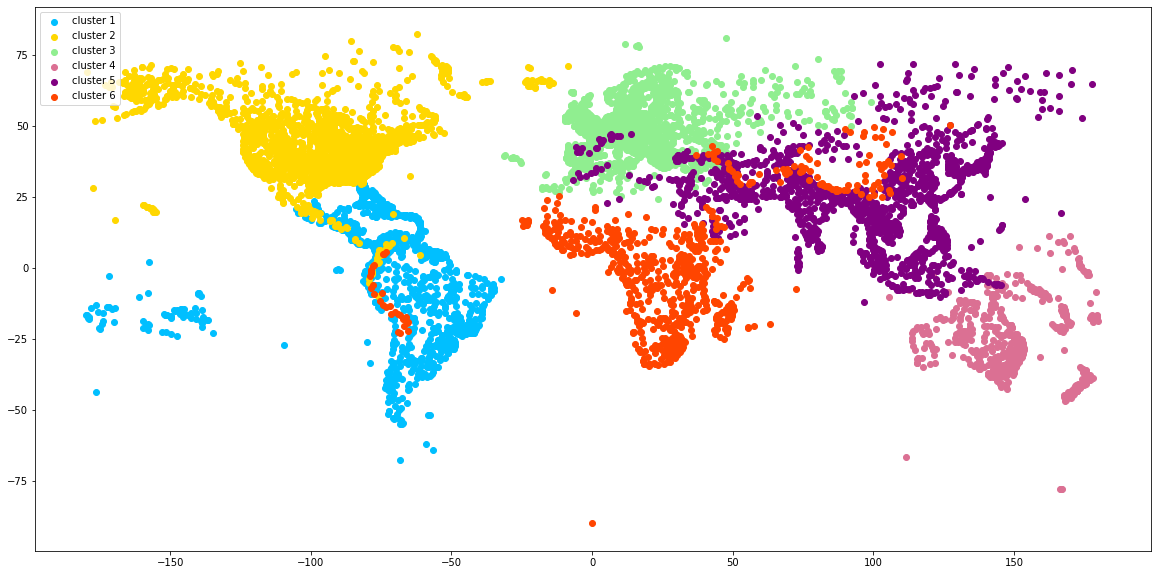

In [126]:
model_agglomerative(df = df, x =x, z = z, t = 5.8)